In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import  MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
%matplotlib inline

from tensorflow.keras.utils import plot_model

#tensorboard: currently some error
#!pip install -U tensorboardcolab
#from tensorboardcolab import *

# json and pretty print
import json
import pprint
# to persist the numpy arrays data
import h5py
# handle logging
tf.logging.set_verbosity(tf.logging.INFO)

print(tf.__version__)
datapath = 'data/interpolated'
df_ibuprofen = pd.read_csv(datapath + '/ibuprofen.csv')
print(df_ibuprofen.dtypes.value_counts())
print(df_ibuprofen.columns.tolist())
print('length of columns :', len(df_ibuprofen.columns.tolist()))
print(df_ibuprofen.count())
df_ibuprofen.head()

1.12.0
float64    2
object     1
dtype: int64
['2017-01-02', '11.80192627826087', '837.8499825787173']
length of columns : 3
2017-01-02           818
11.80192627826087    818
837.8499825787173    818
dtype: int64


,2017-01-02,11.80192627826087,837.8499825787173
0,2017-01-03,11.801926,2144.877216
1,2017-01-04,11.318281,4306.924470
2,2017-01-05,11.409141,3567.215778
3,2017-01-06,11.500000,5029.154075
4,2017-01-07,11.456375,6283.990971


# Functions

In [2]:
# Calculating Mean Absolute Percentage Error of predictions
def calc_mape(predicted_data, true_data):\
    return np.divide(np.sum(np.divide(np.absolute(predicted_data - true_data), true_data), 0), true_data.shape[0])
  
def plot_prediction(original, predicted):
    #fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    # Get subplots
    f, (plt1, plt2, plt3) = plt.subplots(3)
    # Get Daily errors
    
    a = original
    b = predicted
    if(len(original.shape) > 1):
        a = original.reshape(original.shape[0]*original.shape[1])
    if(len(predicted.shape) > 1):
        b = predicted.reshape(predicted.shape[0]*predicted.shape[1])
    
    daily_errors = abs(a - b)
    t = 7
    weekly_errors = temp = [np.float(np.sum(daily_errors[i:i+t])/t) for i in range(0, len(daily_errors), t)]
  
    # Calculate R2 metric
  
    # FROM wikipedia: 
    # Values of R2 outside the range 0 to 1 can occur when the model fits the data worse than a horizontal hyperplane. 
    # This would occur when the wrong model was chosen.
    m = np.mean(a)
    ss_tot = np.sum(np.power((a - m), 2))
    ss_res = np.sum(np.power((a - b), 2))
    r_square = 1 - (ss_res / ss_tot)
    r_square = "{0:.4f}".format(r_square)
    mape = calc_mape(b, a)
  
    # Get weekly errors
    # plot original vs predicted  
    plt1.plot(original, color='black', label = 'Original data') 
    plt1.plot(predicted, color='blue', label = 'Predicted data')

    # PLOT DAILY ERRORS
    plt2.plot(daily_errors, color='red')
    
    # PLOT WEEKLY ERRORS
    for i, e in enumerate(weekly_errors):
        plt3.bar(x=i*7, height=e, width=5, color='red')

    plt1.set_title('Actual and Predicted - R2: '+str(r_square) + ' - MAPE:'+str(mape))  
    plt2.set_title('Daily Errors')
    plt3.set_title('Weekly Errors')
  
    # IF YOU ARE USING COLAB, USE THIS:
    plt.subplots_adjust(left=1, bottom=1, right=4, top=3, wspace=None, hspace=1)
  
    # IF YOU ARE USING YOUR LOCAL AND SHOWING THE RESULTS USE THE FOLLOWING:
    # plt.subplots_adjust(left=0.05, bottom=0.05, right=0.90, top=0.90, wspace=None, hspace=0.4)
    
    plt.show()

# returns normalized dataset between a and b
def minmax_norm(dataset, a, b):
    # NORMALIZE DATASET
    d = dataset
    mi = np.min(dataset)
    ma = np.max(dataset)

    norm_dataset = ((b-a) * ((d - mi)/(ma - mi))) + a
    return norm_dataset

def minmax_denorm(old_data, val, a=-1, b=1):
    mi = min(old_data)
    ma = max(old_data)

    return ((val - a) * (ma-mi) / (b-a)) + mi

def get_test(X, percentage=0.9):
    iXPercentage = int(len(X) * percentage) 
    X_train_val = X[0:iXPercentage]
    X_test = X[iXPercentage:]
    return X_train_val, X_test
  
def get_data_dict(d_list, windows):
    length = len(d_list[0])
    step = 1
    forecast = 1

    _dict = {}
    for window in windows:
        X = []
        Y = []
        for i in range(0, length, step):
            try:
                # Get windowed data
                windowed_features_list = []
                for j in range(len(d_list)):
                    windowed_features_list.append(d_list[j][i:i+window])

                # ALWAYS TAKE THE FIRST data 
                y_i = d_list[0][i + window + forecast - 1] # indexing is important.
                x_i = np.column_stack(tuple(windowed_features_list))
            except Exception as e:
                print(e)
                break
            
            X.append(x_i)
            Y.append(y_i)
            #print(X)
        _dict[window] = {'X': np.array(X), 'Y': np.array(Y)}
    
    return _dict

In [3]:
#choosing current painkiller from the list to make the regression model
CURRENT_SUBSTANCE = '' 

# dictionaries key and value
KEY_PRICE_BASED = "P"
KEY_VOLUME_BASED = "V"

# In total 37 painkillers
ALL_PAINKILLERS_LIST = ['aceclofenac', 'acetylsalicylic-acid', 'benzydamine', 'celecoxib', 'choline-salicylate',
                        'dexibuprofen', 'diacerein', 'diclofenac', 'etodolac', 'etoricoxib', 
                        'feprazone', 'flurbiprofen', 'glucosamine', 'ibuprofen', 'ketoprofen', 
                        'ketorolac', 'lornoxicam', 'mefenamic-acid', 'meloxicam', 'metamizole-sodium', 
                        'nabumetone', 'naproxen', 'nimesulide', 'opium', 'paracetamol', 
                        'penicillamin', 'phenylbutazone', 'piroxicam', 'propyphenazone', 'salicylamide', 
                        'sodium-salicylate', 'tapentadol', 'tenoxicam', 'tilidine', 'tolfenamic-acid',
                        'tramadol', 'viminol']

In [4]:
import glob
all_filenames = glob.glob(datapath+'*/**.csv')
print(all_filenames)

['data\\interpolated\\aceclofenac.csv', 'data\\interpolated\\acetylsalicylic-acid.csv', 'data\\interpolated\\benzydamine.csv', 'data\\interpolated\\celecoxib.csv', 'data\\interpolated\\choline-salicylate.csv', 'data\\interpolated\\dexibuprofen.csv', 'data\\interpolated\\diacerein.csv', 'data\\interpolated\\diclofenac.csv', 'data\\interpolated\\etodolac.csv', 'data\\interpolated\\etoricoxib.csv', 'data\\interpolated\\feprazone.csv', 'data\\interpolated\\flurbiprofen.csv', 'data\\interpolated\\glucosamine.csv', 'data\\interpolated\\ibuprofen.csv', 'data\\interpolated\\ketoprofen.csv', 'data\\interpolated\\ketorolac.csv', 'data\\interpolated\\lornoxicam.csv', 'data\\interpolated\\mefenamic-acid.csv', 'data\\interpolated\\meloxicam.csv', 'data\\interpolated\\metamizole-sodium.csv', 'data\\interpolated\\nabumetone.csv', 'data\\interpolated\\naproxen.csv', 'data\\interpolated\\nimesulide.csv', 'data\\interpolated\\opium.csv', 'data\\interpolated\\paracetamol.csv', 'data\\interpolated\\penici

In [5]:
painkiller_names = []
for csv_file in all_filenames:
    substance = csv_file.split('\\')[-1].split(".")[0]
    print(substance)
    CURRENT_SUBSTANCE = substance
    painkiller_names.append(substance)

assert CURRENT_SUBSTANCE in painkiller_names

aceclofenac
acetylsalicylic-acid
benzydamine
celecoxib
choline-salicylate
dexibuprofen
diacerein
diclofenac
etodolac
etoricoxib
feprazone
flurbiprofen
glucosamine
ibuprofen
ketoprofen
ketorolac
lornoxicam
mefenamic-acid
meloxicam
metamizole-sodium
nabumetone
naproxen
nimesulide
opium
paracetamol
penicillamin
phenylbutazone
piroxicam
propyphenazone
salicylamide
sodium-salicylate
tapentadol
tenoxicam
tilidine
tolfenamic-acid
tramadol
viminol


In [6]:
all_painkiller_dict = {}

# Loading all the painkillers in dictionaries
for csv_file in all_filenames:
    substance = csv_file.split('\\')[-1].split(".")[0]
    print(substance + " | is started to being read")
    try:
        df = df = pd.read_csv(csv_file, header=None)
        dates = df[0]
        prices = df[1]
        volumes = df[2]
    
        all_painkiller_dict[substance] = {}
        all_painkiller_dict[substance][KEY_PRICE_BASED] = prices
        all_painkiller_dict[substance][KEY_VOLUME_BASED] = volumes
    
    except Exception as e:
        print('Error at reading substance | ' + substance)
        print(e)
        break

aceclofenac | is started to being read
acetylsalicylic-acid | is started to being read
benzydamine | is started to being read
celecoxib | is started to being read
choline-salicylate | is started to being read
dexibuprofen | is started to being read
diacerein | is started to being read
diclofenac | is started to being read
etodolac | is started to being read
etoricoxib | is started to being read
feprazone | is started to being read
flurbiprofen | is started to being read
glucosamine | is started to being read
ibuprofen | is started to being read
ketoprofen | is started to being read
ketorolac | is started to being read
lornoxicam | is started to being read
mefenamic-acid | is started to being read
meloxicam | is started to being read
metamizole-sodium | is started to being read
nabumetone | is started to being read
naproxen | is started to being read
nimesulide | is started to being read
opium | is started to being read
paracetamol | is started to being read
penicillamin | is started to

In [44]:
# Test with aceclofenac, paracetamol, ibuprofen
CURRENT_SUBSTANCE = ALL_PAINKILLERS_LIST[24]
print(CURRENT_SUBSTANCE)

paracetamol


In [45]:
all_painkiller_dict[CURRENT_SUBSTANCE]

{'P': 0       5.062047
 1       5.062047
 2       4.050100
 3       3.286644
 4       3.132525
 5       3.053567
 6       3.342180
 7       3.630792
 8       4.238484
 9       4.846176
 10      3.140156
 11      3.877446
 12      3.588089
 13      3.298732
 14      3.009375
 15      3.049000
 16      3.227106
 17      4.401267
 18      2.998000
 19      4.865483
 20      4.702741
 21      4.540000
 22      3.308359
 23      3.141100
 24      3.327278
 25      3.513456
 26      3.679024
 27      3.373144
 28      3.067263
 29      3.216671
          ...    
 789     6.001413
 790     6.136755
 791     6.272096
 792     5.180368
 793     6.167852
 794     4.761712
 795     6.507937
 796     6.254218
 797     6.000499
 798     5.746780
 799     6.435662
 800     6.082712
 801     6.048268
 802     5.266955
 803     6.168095
 804     5.781678
 805     5.395262
 806     6.130351
 807     6.413070
 808     6.278149
 809     5.683550
 810     5.215257
 811     5.706909
 812     6.198561
 813 

In [46]:
df_general = pd.DataFrame.from_dict(all_painkiller_dict[CURRENT_SUBSTANCE])
df_general.head()

,P,V
0,5.062047,1622.446035
1,5.062047,4905.684643
2,4.050100,17063.543608
3,3.286644,48453.956431
4,3.132525,63160.945790


In [47]:
column_names = ['P', 'V']

In [48]:
prices = np.array(df_general[column_names[0]])
volumes = np.array(df_general[column_names[1]])
#print(prices)
#print(volumes)

In [49]:
non_normalized_data = get_data_dict(d_list=[prices, volumes], windows=[6, 8, 12])

x = non_normalized_data[6]['X']
y = non_normalized_data[6]['Y']
print(x[0])
print(y[0])
print('*'*100)
print(x[1])
print(y[1])
print('*'*100)

index 819 is out of bounds for axis 0 with size 819
index 819 is out of bounds for axis 0 with size 819
index 819 is out of bounds for axis 0 with size 819
[[5.06204651e+00 1.62244603e+03]
 [5.06204651e+00 4.90568464e+03]
 [4.05010000e+00 1.70635436e+04]
 [3.28664437e+00 4.84539564e+04]
 [3.13252469e+00 6.31609458e+04]
 [3.05356667e+00 4.35303300e+04]]
3.3421795035460997
****************************************************************************************************
[[5.06204651e+00 4.90568464e+03]
 [4.05010000e+00 1.70635436e+04]
 [3.28664437e+00 4.84539564e+04]
 [3.13252469e+00 6.31609458e+04]
 [3.05356667e+00 4.35303300e+04]
 [3.34217950e+00 2.33400263e+04]]
3.630792340425532
****************************************************************************************************


In [50]:
# Extract Test
daily_prices, test_daily_prices = get_test(prices)
daily_volumes, test_daily_volumes = get_test(volumes)
#print(len(daily_prices))
print(daily_prices.shape)

(737,)


In [51]:
data_dict = get_data_dict(d_list=[daily_prices, daily_volumes], 
                                windows=[6,8,12])
x = data_dict[6]['X']
y = data_dict[6]['Y']
print(x[0])
print(y[0])
print('*'*100)
print(x[1])
print(y[1])
print('*'*100)

index 737 is out of bounds for axis 0 with size 737
index 737 is out of bounds for axis 0 with size 737
index 737 is out of bounds for axis 0 with size 737
[[5.06204651e+00 1.62244603e+03]
 [5.06204651e+00 4.90568464e+03]
 [4.05010000e+00 1.70635436e+04]
 [3.28664437e+00 4.84539564e+04]
 [3.13252469e+00 6.31609458e+04]
 [3.05356667e+00 4.35303300e+04]]
3.3421795035460997
****************************************************************************************************
[[5.06204651e+00 4.90568464e+03]
 [4.05010000e+00 1.70635436e+04]
 [3.28664437e+00 4.84539564e+04]
 [3.13252469e+00 6.31609458e+04]
 [3.05356667e+00 4.35303300e+04]
 [3.34217950e+00 2.33400263e+04]]
3.630792340425532
****************************************************************************************************


In [52]:
norm_daily_prices  = minmax_norm(daily_prices, a=-1, b=1)
norm_daily_volumes = minmax_norm(daily_volumes, a=-1, b=1)

normalized_data = get_data_dict(d_list=[norm_daily_prices, norm_daily_volumes], 
                                windows=[6,8,12])

index 737 is out of bounds for axis 0 with size 737
index 737 is out of bounds for axis 0 with size 737
index 737 is out of bounds for axis 0 with size 737


In [53]:
x = normalized_data[6]['X']
y = normalized_data[6]['Y']
print(x[0])
print(y[0])
print('*'*100)
print(x[1])
print(y[1])
print('*'*100)

[[-0.85396504 -0.97538965]
 [-0.85396504 -0.91019165]
 [-0.89566894 -0.66876293]
 [-0.92713213 -0.04541738]
 [-0.93348365  0.24663154]
 [-0.93673763 -0.14318993]]
-0.924843443468576
****************************************************************************************************
[[-0.85396504 -0.91019165]
 [-0.89566894 -0.66876293]
 [-0.92713213 -0.04541738]
 [-0.93348365  0.24663154]
 [-0.93673763 -0.14318993]
 [-0.92484344 -0.54412559]]
-0.9129492582640131
****************************************************************************************************


# BI-DIR LSTM

In [54]:
w = 6
#w = 8
#w = 12
batch_size = 32

In [55]:
def build_model(tensor_shape):
    #create model
    model = keras.Sequential()
    units = tensor_shape[0]
    #model.add(layers.Bidirectional(LSTM(units, return_sequences=True, activation='relu'), input_shape=(tensor_shape[0], tensor_shape[1])))
    model.add(layers.Bidirectional(LSTM(units, return_sequences=True), batch_input_shape=(None, tensor_shape[0], tensor_shape[1])))
    
    
    #model.add(layers.Bidirectional(layers.LSTM(5, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]))))
    #model.add(layers.LSTM(4, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
    #model.add(layers.LSTM(32, activation='relu'))
    model.add(Flatten())
    model.add(layers.Dense(1))
    #optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
    return model

In [56]:
model = build_model(tensor_shape=(w, 2))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 6, 12)             432       
_________________________________________________________________
flatten_1 (Flatten)          (None, 72)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 73        
Total params: 505
Trainable params: 505
Non-trainable params: 0
_________________________________________________________________


In [57]:
learning_rate=0.0001
epochs=1000
verbose=1
model_dir = 'models/'
model_save_name = model_dir + 'bidirlstm_multivariate_model_' + CURRENT_SUBSTANCE + '_interpolated_data_price_norm.h5'
    
#opt_1 = tf.keras.optimizers.Adam(learning_rate)
opt_1 = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
loss_func = tf.keras.losses.mean_squared_error

metrics = []
metrics.append(tf.keras.metrics.mean_absolute_error)
metrics.append(tf.keras.metrics.mean_squared_error)
metrics.append(tf.keras.metrics.mean_absolute_percentage_error)

print("Model will be saved at: " + model_save_name)
model.compile(optimizer=opt_1, 
                  loss=loss_func, 
                  metrics=metrics)
    
callbacks = []
cp = tf.keras.callbacks.ModelCheckpoint(filepath=model_save_name, verbose=1, save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
    
callbacks.append(cp)
callbacks.append(early_stop)    

Model will be saved at: models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_norm.h5


In [58]:
def get_train_validation(X, y, percentage=0.8):
    iXPercentage = int(len(X) * percentage) 
    iYPercentage = int(len(y) * percentage)
    X_train = X[0:iXPercentage]
    Y_train = y[0:iYPercentage]
    
    #X_train, Y_train = shuffle_in_unison(X_train, Y_train)

    X_val = X[iXPercentage:]
    Y_val = y[iYPercentage:]
    return X_train, X_val, Y_train, Y_val

In [59]:
nX = normalized_data[w]['X']
nY = normalized_data[w]['Y']
X_train, X_val, Y_train, Y_val = get_train_validation(nX, nY)

In [60]:
print('X_train: '+str(X_train.shape))
print('X_val: '+str(X_val.shape))

X_train: (584, 6, 2)
X_val: (147, 6, 2)


In [61]:
print(X_train[0])
print(Y_train[0])
print('*'*50)
print(X_train[1])
print(Y_train[1])
print('*'*50)

[[-0.85396504 -0.97538965]
 [-0.85396504 -0.91019165]
 [-0.89566894 -0.66876293]
 [-0.92713213 -0.04541738]
 [-0.93348365  0.24663154]
 [-0.93673763 -0.14318993]]
-0.924843443468576
**************************************************
[[-0.85396504 -0.91019165]
 [-0.89566894 -0.66876293]
 [-0.92713213 -0.04541738]
 [-0.93348365  0.24663154]
 [-0.93673763 -0.14318993]
 [-0.92484344 -0.54412559]]
-0.9129492582640131
**************************************************


In [62]:
history = model.fit(X_train, Y_train, 
                    epochs = epochs,  batch_size = batch_size, 
                    verbose=verbose, validation_data=(X_val, Y_val), validation_split=0.8, callbacks=callbacks)

Train on 584 samples, validate on 147 samples
Epoch 1/1000
576/584 [============================>.] - ETA: 0s - loss: 0.8165 - mean_absolute_error: 0.8996 - mean_squared_error: 0.8165 - mean_absolute_percentage_error: 102.7668
Epoch 00001: val_loss improved from inf to 0.70559, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_norm.h5
584/584 [==============================] - 3s 6ms/step - loss: 0.8160 - mean_absolute_error: 0.8994 - mean_squared_error: 0.8160 - mean_absolute_percentage_error: 102.7307 - val_loss: 0.7056 - val_mean_absolute_error: 0.8388 - val_mean_squared_error: 0.7056 - val_mean_absolute_percentage_error: 100.8189
Epoch 2/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.7654 - mean_absolute_error: 0.8706 - mean_squared_error: 0.7654 - mean_absolute_percentage_error: 99.5767
Epoch 00002: val_loss improved from 0.70559 to 0.65495, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_pr

Epoch 14/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.3400 - mean_absolute_error: 0.5754 - mean_squared_error: 0.3400 - mean_absolute_percentage_error: 66.6861
Epoch 00014: val_loss improved from 0.27216 to 0.24688, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_norm.h5
584/584 [==============================] - 0s 828us/step - loss: 0.3387 - mean_absolute_error: 0.5740 - mean_squared_error: 0.3387 - mean_absolute_percentage_error: 66.3639 - val_loss: 0.2469 - val_mean_absolute_error: 0.4936 - val_mean_squared_error: 0.2469 - val_mean_absolute_percentage_error: 59.2953
Epoch 15/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.3154 - mean_absolute_error: 0.5536 - mean_squared_error: 0.3154 - mean_absolute_percentage_error: 64.2455
Epoch 00015: val_loss improved from 0.24688 to 0.22282, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_norm.h5
584/584 [====================

Epoch 27/1000
576/584 [============================>.] - ETA: 0s - loss: 0.0924 - mean_absolute_error: 0.2753 - mean_squared_error: 0.0924 - mean_absolute_percentage_error: 33.9557
Epoch 00027: val_loss improved from 0.04471 to 0.03662, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_norm.h5
584/584 [==============================] - 1s 926us/step - loss: 0.0926 - mean_absolute_error: 0.2756 - mean_squared_error: 0.0926 - mean_absolute_percentage_error: 33.9557 - val_loss: 0.0366 - val_mean_absolute_error: 0.1749 - val_mean_squared_error: 0.0366 - val_mean_absolute_percentage_error: 20.9595
Epoch 28/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.0849 - mean_absolute_error: 0.2588 - mean_squared_error: 0.0849 - mean_absolute_percentage_error: 32.6225
Epoch 00028: val_loss improved from 0.03662 to 0.02969, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_norm.h5
584/584 [====================

576/584 [============================>.] - ETA: 0s - loss: 0.0326 - mean_absolute_error: 0.1243 - mean_squared_error: 0.0326 - mean_absolute_percentage_error: 18.2228
Epoch 00040: val_loss did not improve from 0.00764
584/584 [==============================] - 0s 798us/step - loss: 0.0325 - mean_absolute_error: 0.1246 - mean_squared_error: 0.0325 - mean_absolute_percentage_error: 18.1921 - val_loss: 0.0082 - val_mean_absolute_error: 0.0720 - val_mean_squared_error: 0.0082 - val_mean_absolute_percentage_error: 8.7097
Epoch 41/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.0325 - mean_absolute_error: 0.1227 - mean_squared_error: 0.0325 - mean_absolute_percentage_error: 18.6237
Epoch 00041: val_loss did not improve from 0.00764
584/584 [==============================] - 0s 763us/step - loss: 0.0316 - mean_absolute_error: 0.1221 - mean_squared_error: 0.0316 - mean_absolute_percentage_error: 17.9756 - val_loss: 0.0086 - val_mean_absolute_error: 0.0740 - val_mean_squared_e

512/584 [=========================>....] - ETA: 0s - loss: 0.0287 - mean_absolute_error: 0.1123 - mean_squared_error: 0.0287 - mean_absolute_percentage_error: 17.7630
Epoch 00055: val_loss did not improve from 0.00764
584/584 [==============================] - 0s 778us/step - loss: 0.0271 - mean_absolute_error: 0.1108 - mean_squared_error: 0.0271 - mean_absolute_percentage_error: 17.0019 - val_loss: 0.0109 - val_mean_absolute_error: 0.0857 - val_mean_squared_error: 0.0109 - val_mean_absolute_percentage_error: 10.3922
Epoch 56/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.0281 - mean_absolute_error: 0.1113 - mean_squared_error: 0.0281 - mean_absolute_percentage_error: 17.6966
Epoch 00056: val_loss did not improve from 0.00764
584/584 [==============================] - 0s 763us/step - loss: 0.0269 - mean_absolute_error: 0.1102 - mean_squared_error: 0.0269 - mean_absolute_percentage_error: 16.9395 - val_loss: 0.0108 - val_mean_absolute_error: 0.0853 - val_mean_squared_

512/584 [=========================>....] - ETA: 0s - loss: 0.0238 - mean_absolute_error: 0.0998 - mean_squared_error: 0.0238 - mean_absolute_percentage_error: 15.3804
Epoch 00070: val_loss did not improve from 0.00764
584/584 [==============================] - 0s 749us/step - loss: 0.0242 - mean_absolute_error: 0.1015 - mean_squared_error: 0.0242 - mean_absolute_percentage_error: 15.9914 - val_loss: 0.0094 - val_mean_absolute_error: 0.0802 - val_mean_squared_error: 0.0094 - val_mean_absolute_percentage_error: 9.7327
Epoch 71/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.0240 - mean_absolute_error: 0.1006 - mean_squared_error: 0.0240 - mean_absolute_percentage_error: 15.4963
Epoch 00071: val_loss did not improve from 0.00764
584/584 [==============================] - 0s 745us/step - loss: 0.0240 - mean_absolute_error: 0.1008 - mean_squared_error: 0.0240 - mean_absolute_percentage_error: 15.9226 - val_loss: 0.0093 - val_mean_absolute_error: 0.0798 - val_mean_squared_e

512/584 [=========================>....] - ETA: 0s - loss: 0.0212 - mean_absolute_error: 0.0906 - mean_squared_error: 0.0212 - mean_absolute_percentage_error: 14.4174
Epoch 00085: val_loss did not improve from 0.00764
584/584 [==============================] - 0s 760us/step - loss: 0.0215 - mean_absolute_error: 0.0918 - mean_squared_error: 0.0215 - mean_absolute_percentage_error: 14.9193 - val_loss: 0.0077 - val_mean_absolute_error: 0.0723 - val_mean_squared_error: 0.0077 - val_mean_absolute_percentage_error: 8.7803
Epoch 86/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.0211 - mean_absolute_error: 0.0897 - mean_squared_error: 0.0211 - mean_absolute_percentage_error: 14.6596
Epoch 00086: val_loss did not improve from 0.00764
584/584 [==============================] - 0s 766us/step - loss: 0.0213 - mean_absolute_error: 0.0912 - mean_squared_error: 0.0213 - mean_absolute_percentage_error: 14.8590 - val_loss: 0.0077 - val_mean_absolute_error: 0.0727 - val_mean_squared_e

584/584 [==============================] - 0s 813us/step - loss: 0.0194 - mean_absolute_error: 0.0833 - mean_squared_error: 0.0194 - mean_absolute_percentage_error: 13.9751 - val_loss: 0.0064 - val_mean_absolute_error: 0.0661 - val_mean_squared_error: 0.0064 - val_mean_absolute_percentage_error: 8.0386
Epoch 99/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.0180 - mean_absolute_error: 0.0785 - mean_squared_error: 0.0180 - mean_absolute_percentage_error: 12.7314
Epoch 00099: val_loss did not improve from 0.00637
584/584 [==============================] - 0s 773us/step - loss: 0.0192 - mean_absolute_error: 0.0827 - mean_squared_error: 0.0192 - mean_absolute_percentage_error: 13.9179 - val_loss: 0.0065 - val_mean_absolute_error: 0.0670 - val_mean_squared_error: 0.0065 - val_mean_absolute_percentage_error: 8.1499
Epoch 100/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.0206 - mean_absolute_error: 0.0843 - mean_squared_error: 0.0206 - mean_absolute_perc

Epoch 112/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.0698 - mean_squared_error: 0.0112 - mean_absolute_percentage_error: 13.0387
Epoch 00112: val_loss did not improve from 0.00534
584/584 [==============================] - 0s 783us/step - loss: 0.0173 - mean_absolute_error: 0.0741 - mean_squared_error: 0.0173 - mean_absolute_percentage_error: 12.9786 - val_loss: 0.0054 - val_mean_absolute_error: 0.0612 - val_mean_squared_error: 0.0054 - val_mean_absolute_percentage_error: 7.4516
Epoch 113/1000
576/584 [============================>.] - ETA: 0s - loss: 0.0172 - mean_absolute_error: 0.0731 - mean_squared_error: 0.0172 - mean_absolute_percentage_error: 12.9343
Epoch 00113: val_loss improved from 0.00534 to 0.00524, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_norm.h5
584/584 [==============================] - 1s 862us/step - loss: 0.0172 - mean_absolute_error: 0.0734 - mean_squared_error: 0.017

512/584 [=========================>....] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.0628 - mean_squared_error: 0.0101 - mean_absolute_percentage_error: 12.4159
Epoch 00125: val_loss improved from 0.00431 to 0.00429, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_norm.h5
584/584 [==============================] - 0s 809us/step - loss: 0.0157 - mean_absolute_error: 0.0655 - mean_squared_error: 0.0157 - mean_absolute_percentage_error: 12.0348 - val_loss: 0.0043 - val_mean_absolute_error: 0.0545 - val_mean_squared_error: 0.0043 - val_mean_absolute_percentage_error: 6.6618
Epoch 126/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.0166 - mean_absolute_error: 0.0650 - mean_squared_error: 0.0166 - mean_absolute_percentage_error: 12.5320
Epoch 00126: val_loss improved from 0.00429 to 0.00384, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_norm.h5
584/584 [==============================] - 

Epoch 139/1000
576/584 [============================>.] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0542 - mean_squared_error: 0.0084 - mean_absolute_percentage_error: 10.8778
Epoch 00139: val_loss improved from 0.00336 to 0.00334, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_norm.h5
584/584 [==============================] - 0s 829us/step - loss: 0.0143 - mean_absolute_error: 0.0571 - mean_squared_error: 0.0143 - mean_absolute_percentage_error: 11.0952 - val_loss: 0.0033 - val_mean_absolute_error: 0.0478 - val_mean_squared_error: 0.0033 - val_mean_absolute_percentage_error: 5.8598
Epoch 140/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.0153 - mean_absolute_error: 0.0571 - mean_squared_error: 0.0153 - mean_absolute_percentage_error: 11.6923
Epoch 00140: val_loss improved from 0.00334 to 0.00283, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_norm.h5
584/584 [===================

Epoch 154/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.0147 - mean_absolute_error: 0.0511 - mean_squared_error: 0.0147 - mean_absolute_percentage_error: 11.0443
Epoch 00154: val_loss improved from 0.00260 to 0.00258, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_norm.h5
584/584 [==============================] - 0s 811us/step - loss: 0.0133 - mean_absolute_error: 0.0501 - mean_squared_error: 0.0133 - mean_absolute_percentage_error: 10.3047 - val_loss: 0.0026 - val_mean_absolute_error: 0.0409 - val_mean_squared_error: 0.0026 - val_mean_absolute_percentage_error: 5.0351
Epoch 155/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.0125 - mean_absolute_error: 0.0477 - mean_squared_error: 0.0125 - mean_absolute_percentage_error: 6.8474
Epoch 00155: val_loss did not improve from 0.00258
584/584 [==============================] - 0s 788us/step - loss: 0.0132 - mean_absolute_error: 0.0495 - mean_squared_error: 0.0132

Epoch 169/1000
576/584 [============================>.] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0457 - mean_squared_error: 0.0128 - mean_absolute_percentage_error: 9.8780 
Epoch 00169: val_loss did not improve from 0.00206
584/584 [==============================] - 0s 814us/step - loss: 0.0127 - mean_absolute_error: 0.0457 - mean_squared_error: 0.0127 - mean_absolute_percentage_error: 9.8270 - val_loss: 0.0022 - val_mean_absolute_error: 0.0365 - val_mean_squared_error: 0.0022 - val_mean_absolute_percentage_error: 4.5160
Epoch 170/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0442 - mean_squared_error: 0.0073 - mean_absolute_percentage_error: 10.3610
Epoch 00170: val_loss did not improve from 0.00206
584/584 [==============================] - 0s 758us/step - loss: 0.0127 - mean_absolute_error: 0.0454 - mean_squared_error: 0.0127 - mean_absolute_percentage_error: 9.7992 - val_loss: 0.0022 - val_mean_absolute_error: 0.0367 - val_

Epoch 184/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.0131 - mean_absolute_error: 0.0438 - mean_squared_error: 0.0131 - mean_absolute_percentage_error: 9.9133 
Epoch 00184: val_loss did not improve from 0.00197
584/584 [==============================] - 0s 781us/step - loss: 0.0124 - mean_absolute_error: 0.0438 - mean_squared_error: 0.0124 - mean_absolute_percentage_error: 9.6122 - val_loss: 0.0020 - val_mean_absolute_error: 0.0331 - val_mean_squared_error: 0.0020 - val_mean_absolute_percentage_error: 4.1049
Epoch 185/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.0443 - mean_squared_error: 0.0133 - mean_absolute_percentage_error: 10.0093
Epoch 00185: val_loss did not improve from 0.00197
584/584 [==============================] - 0s 766us/step - loss: 0.0124 - mean_absolute_error: 0.0437 - mean_squared_error: 0.0124 - mean_absolute_percentage_error: 9.6032 - val_loss: 0.0020 - val_mean_absolute_error: 0.0325 - val_

Epoch 199/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.0135 - mean_absolute_error: 0.0426 - mean_squared_error: 0.0135 - mean_absolute_percentage_error: 10.0967
Epoch 00199: val_loss did not improve from 0.00188
584/584 [==============================] - 0s 785us/step - loss: 0.0123 - mean_absolute_error: 0.0422 - mean_squared_error: 0.0123 - mean_absolute_percentage_error: 9.4557 - val_loss: 0.0020 - val_mean_absolute_error: 0.0316 - val_mean_squared_error: 0.0020 - val_mean_absolute_percentage_error: 3.9281
Epoch 200/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.0364 - mean_squared_error: 0.0046 - mean_absolute_percentage_error: 8.1316
Epoch 00200: val_loss did not improve from 0.00188
584/584 [==============================] - 0s 763us/step - loss: 0.0123 - mean_absolute_error: 0.0423 - mean_squared_error: 0.0123 - mean_absolute_percentage_error: 9.4582 - val_loss: 0.0021 - val_mean_absolute_error: 0.0331 - val_m

512/584 [=========================>....] - ETA: 0s - loss: 0.0136 - mean_absolute_error: 0.0438 - mean_squared_error: 0.0136 - mean_absolute_percentage_error: 10.2241
Epoch 00214: val_loss did not improve from 0.00182
584/584 [==============================] - 0s 767us/step - loss: 0.0123 - mean_absolute_error: 0.0425 - mean_squared_error: 0.0123 - mean_absolute_percentage_error: 9.4618 - val_loss: 0.0019 - val_mean_absolute_error: 0.0303 - val_mean_squared_error: 0.0019 - val_mean_absolute_percentage_error: 3.7722
Epoch 215/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.0138 - mean_absolute_error: 0.0435 - mean_squared_error: 0.0138 - mean_absolute_percentage_error: 10.2451
Epoch 00215: val_loss did not improve from 0.00182
584/584 [==============================] - 0s 750us/step - loss: 0.0123 - mean_absolute_error: 0.0420 - mean_squared_error: 0.0123 - mean_absolute_percentage_error: 9.4235 - val_loss: 0.0019 - val_mean_absolute_error: 0.0310 - val_mean_squared_er

512/584 [=========================>....] - ETA: 0s - loss: 0.0136 - mean_absolute_error: 0.0427 - mean_squared_error: 0.0136 - mean_absolute_percentage_error: 10.1486
Epoch 00229: val_loss did not improve from 0.00177
584/584 [==============================] - 0s 781us/step - loss: 0.0122 - mean_absolute_error: 0.0418 - mean_squared_error: 0.0122 - mean_absolute_percentage_error: 9.4012 - val_loss: 0.0019 - val_mean_absolute_error: 0.0305 - val_mean_squared_error: 0.0019 - val_mean_absolute_percentage_error: 3.7963
Epoch 230/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.0132 - mean_absolute_error: 0.0412 - mean_squared_error: 0.0132 - mean_absolute_percentage_error: 9.8731 
Epoch 00230: val_loss did not improve from 0.00177
584/584 [==============================] - 0s 766us/step - loss: 0.0122 - mean_absolute_error: 0.0417 - mean_squared_error: 0.0122 - mean_absolute_percentage_error: 9.3870 - val_loss: 0.0019 - val_mean_absolute_error: 0.0311 - val_mean_squared_er

512/584 [=========================>....] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0374 - mean_squared_error: 0.0055 - mean_absolute_percentage_error: 8.6174
Epoch 00244: val_loss did not improve from 0.00177
584/584 [==============================] - 0s 782us/step - loss: 0.0122 - mean_absolute_error: 0.0413 - mean_squared_error: 0.0122 - mean_absolute_percentage_error: 9.3494 - val_loss: 0.0020 - val_mean_absolute_error: 0.0320 - val_mean_squared_error: 0.0020 - val_mean_absolute_percentage_error: 3.9807
Epoch 245/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.0135 - mean_absolute_error: 0.0417 - mean_squared_error: 0.0135 - mean_absolute_percentage_error: 9.9904
Epoch 00245: val_loss did not improve from 0.00177
584/584 [==============================] - 0s 765us/step - loss: 0.0122 - mean_absolute_error: 0.0415 - mean_squared_error: 0.0122 - mean_absolute_percentage_error: 9.3549 - val_loss: 0.0019 - val_mean_absolute_error: 0.0300 - val_mean_squared_erro

512/584 [=========================>....] - ETA: 0s - loss: 0.0136 - mean_absolute_error: 0.0429 - mean_squared_error: 0.0136 - mean_absolute_percentage_error: 10.1490 
Epoch 00259: val_loss did not improve from 0.00177
584/584 [==============================] - 1s 858us/step - loss: 0.0122 - mean_absolute_error: 0.0414 - mean_squared_error: 0.0122 - mean_absolute_percentage_error: 9.3466 - val_loss: 0.0018 - val_mean_absolute_error: 0.0293 - val_mean_squared_error: 0.0018 - val_mean_absolute_percentage_error: 3.6524
Epoch 260/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.0431 - mean_squared_error: 0.0133 - mean_absolute_percentage_error: 10.0570
Epoch 00260: val_loss did not improve from 0.00177
584/584 [==============================] - 0s 757us/step - loss: 0.0122 - mean_absolute_error: 0.0423 - mean_squared_error: 0.0122 - mean_absolute_percentage_error: 9.4155 - val_loss: 0.0018 - val_mean_absolute_error: 0.0296 - val_mean_squared_e

512/584 [=========================>....] - ETA: 0s - loss: 0.0136 - mean_absolute_error: 0.0425 - mean_squared_error: 0.0136 - mean_absolute_percentage_error: 10.1051  
Epoch 00274: val_loss did not improve from 0.00174
584/584 [==============================] - 0s 755us/step - loss: 0.0122 - mean_absolute_error: 0.0409 - mean_squared_error: 0.0122 - mean_absolute_percentage_error: 9.3039 - val_loss: 0.0020 - val_mean_absolute_error: 0.0322 - val_mean_squared_error: 0.0020 - val_mean_absolute_percentage_error: 4.0012
Epoch 275/1000
544/584 [==========================>...] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0416 - mean_squared_error: 0.0129 - mean_absolute_percentage_error: 9.7036
Epoch 00275: val_loss did not improve from 0.00174
584/584 [==============================] - 0s 801us/step - loss: 0.0122 - mean_absolute_error: 0.0411 - mean_squared_error: 0.0122 - mean_absolute_percentage_error: 9.3083 - val_loss: 0.0019 - val_mean_absolute_error: 0.0310 - val_mean_squared_e

576/584 [============================>.] - ETA: 0s - loss: 0.0123 - mean_absolute_error: 0.0408 - mean_squared_error: 0.0123 - mean_absolute_percentage_error: 9.3538
Epoch 00289: val_loss did not improve from 0.00174
584/584 [==============================] - 1s 2ms/step - loss: 0.0121 - mean_absolute_error: 0.0408 - mean_squared_error: 0.0121 - mean_absolute_percentage_error: 9.2853 - val_loss: 0.0019 - val_mean_absolute_error: 0.0304 - val_mean_squared_error: 0.0019 - val_mean_absolute_percentage_error: 3.7872
Epoch 290/1000
576/584 [============================>.] - ETA: 0s - loss: 0.0123 - mean_absolute_error: 0.0409 - mean_squared_error: 0.0123 - mean_absolute_percentage_error: 9.3536
Epoch 00290: val_loss did not improve from 0.00174
584/584 [==============================] - 1s 2ms/step - loss: 0.0121 - mean_absolute_error: 0.0409 - mean_squared_error: 0.0121 - mean_absolute_percentage_error: 9.2850 - val_loss: 0.0019 - val_mean_absolute_error: 0.0307 - val_mean_squared_error: 0

Epoch 305/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.0131 - mean_absolute_error: 0.0402 - mean_squared_error: 0.0131 - mean_absolute_percentage_error: 9.7859    
Epoch 00305: val_loss did not improve from 0.00174
584/584 [==============================] - 0s 763us/step - loss: 0.0121 - mean_absolute_error: 0.0400 - mean_squared_error: 0.0121 - mean_absolute_percentage_error: 9.2146 - val_loss: 0.0020 - val_mean_absolute_error: 0.0316 - val_mean_squared_error: 0.0020 - val_mean_absolute_percentage_error: 3.9344
Epoch 306/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.0135 - mean_absolute_error: 0.0419 - mean_squared_error: 0.0135 - mean_absolute_percentage_error: 10.0456
Epoch 00306: val_loss did not improve from 0.00174
584/584 [==============================] - 0s 785us/step - loss: 0.0121 - mean_absolute_error: 0.0409 - mean_squared_error: 0.0121 - mean_absolute_percentage_error: 9.2734 - val_loss: 0.0018 - val_mean_absolute_error: 0.0292 - v

544/584 [==========================>...] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0411 - mean_squared_error: 0.0129 - mean_absolute_percentage_error: 9.6526 
Epoch 00320: val_loss did not improve from 0.00174
584/584 [==============================] - 0s 847us/step - loss: 0.0121 - mean_absolute_error: 0.0400 - mean_squared_error: 0.0121 - mean_absolute_percentage_error: 9.1864 - val_loss: 0.0021 - val_mean_absolute_error: 0.0334 - val_mean_squared_error: 0.0021 - val_mean_absolute_percentage_error: 4.1487
Epoch 321/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.0134 - mean_absolute_error: 0.0417 - mean_squared_error: 0.0134 - mean_absolute_percentage_error: 10.0009 
Epoch 00321: val_loss did not improve from 0.00174
584/584 [==============================] - 0s 783us/step - loss: 0.0121 - mean_absolute_error: 0.0405 - mean_squared_error: 0.0121 - mean_absolute_percentage_error: 9.2457 - val_loss: 0.0019 - val_mean_absolute_error: 0.0302 - val_mean_squared_e

512/584 [=========================>....] - ETA: 0s - loss: 0.0135 - mean_absolute_error: 0.0422 - mean_squared_error: 0.0135 - mean_absolute_percentage_error: 10.0566
Epoch 00335: val_loss did not improve from 0.00174
584/584 [==============================] - 0s 774us/step - loss: 0.0120 - mean_absolute_error: 0.0408 - mean_squared_error: 0.0120 - mean_absolute_percentage_error: 9.2469 - val_loss: 0.0018 - val_mean_absolute_error: 0.0296 - val_mean_squared_error: 0.0018 - val_mean_absolute_percentage_error: 3.6820
Epoch 336/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.0134 - mean_absolute_error: 0.0422 - mean_squared_error: 0.0134 - mean_absolute_percentage_error: 10.0426
Epoch 00336: val_loss did not improve from 0.00174
584/584 [==============================] - 0s 757us/step - loss: 0.0120 - mean_absolute_error: 0.0411 - mean_squared_error: 0.0120 - mean_absolute_percentage_error: 9.2663 - val_loss: 0.0019 - val_mean_absolute_error: 0.0302 - val_mean_squared_er

576/584 [============================>.] - ETA: 0s - loss: 0.0121 - mean_absolute_error: 0.0404 - mean_squared_error: 0.0121 - mean_absolute_percentage_error: 9.2666 
Epoch 00350: val_loss did not improve from 0.00174
584/584 [==============================] - 0s 834us/step - loss: 0.0120 - mean_absolute_error: 0.0405 - mean_squared_error: 0.0120 - mean_absolute_percentage_error: 9.2155 - val_loss: 0.0020 - val_mean_absolute_error: 0.0318 - val_mean_squared_error: 0.0020 - val_mean_absolute_percentage_error: 3.9563
Epoch 351/1000
576/584 [============================>.] - ETA: 0s - loss: 0.0122 - mean_absolute_error: 0.0401 - mean_squared_error: 0.0122 - mean_absolute_percentage_error: 9.2500
Epoch 00351: val_loss did not improve from 0.00174
584/584 [==============================] - 0s 765us/step - loss: 0.0120 - mean_absolute_error: 0.0399 - mean_squared_error: 0.0120 - mean_absolute_percentage_error: 9.1626 - val_loss: 0.0020 - val_mean_absolute_error: 0.0316 - val_mean_squared_err

Epoch 365/1000
544/584 [==========================>...] - ETA: 0s - loss: 0.0118 - mean_absolute_error: 0.0392 - mean_squared_error: 0.0118 - mean_absolute_percentage_error: 9.0271
Epoch 00365: val_loss did not improve from 0.00174
584/584 [==============================] - 1s 1ms/step - loss: 0.0120 - mean_absolute_error: 0.0402 - mean_squared_error: 0.0120 - mean_absolute_percentage_error: 9.1800 - val_loss: 0.0019 - val_mean_absolute_error: 0.0303 - val_mean_squared_error: 0.0019 - val_mean_absolute_percentage_error: 3.7722
Epoch 366/1000
544/584 [==========================>...] - ETA: 0s - loss: 0.0115 - mean_absolute_error: 0.0394 - mean_squared_error: 0.0115 - mean_absolute_percentage_error: 6.1734
Epoch 00366: val_loss did not improve from 0.00174
584/584 [==============================] - 1s 1ms/step - loss: 0.0120 - mean_absolute_error: 0.0400 - mean_squared_error: 0.0120 - mean_absolute_percentage_error: 9.1575 - val_loss: 0.0020 - val_mean_absolute_error: 0.0318 - val_mean_s

In [63]:
model.evaluate(X_val, Y_val)

147/147 [==============================] - 0s 2ms/step


[0.0018784235628340772,
 0.03033723111967651,
 0.0018784235628340772,
 3.7783151191919027]

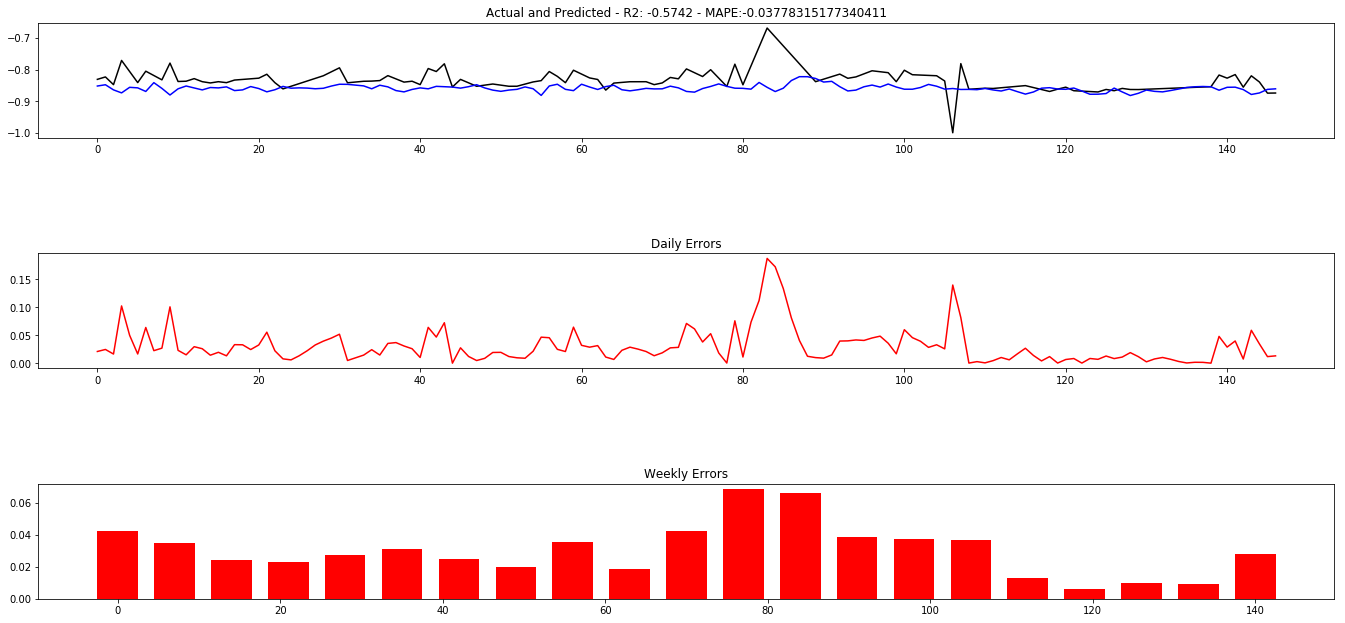

In [64]:
 plot_prediction(Y_val, model.predict(X_val))

# TEST

In [65]:
norm_test_daily_prices = minmax_norm(test_daily_prices, a=-1, b=1)
norm_test_daily_volumes = minmax_norm(test_daily_volumes, a=-1, b=1)

# Not Normalized

In [66]:
#normalized d_list
d_list = [test_daily_prices, test_daily_volumes]

#NOT normalized d_list
#d_list = [weekly_prices, weekly_volumes]

length = len(d_list[0])
step = 1
forecast = 1
windows = [6, 8, 12]

test_data_dict = {}
for window in windows:
    X = []
    Y = []
    for i in range(0, length, step):
        try:
            # Get windowed data
            windowed_features_list = []
            for j in range(len(d_list)):
                windowed_features_list.append(d_list[j][i:i+window])

            # ALWAYS TAKE THE FIRST data 
            y_i = d_list[0][i + window + forecast - 1] # indexing is important.
            x_i = np.column_stack(tuple(windowed_features_list))
        except Exception as e:
            print(e)
            break
        X.append(x_i)
        Y.append(y_i)
    test_data_dict[window] = {'X': np.array(X), 'Y': np.array(Y)}

index 82 is out of bounds for axis 0 with size 82
index 82 is out of bounds for axis 0 with size 82
index 82 is out of bounds for axis 0 with size 82


# Normalized

In [67]:
#normalized d_list
d_list = [norm_test_daily_prices, norm_test_daily_volumes]

#NOT normalized d_list
#d_list = [weekly_prices, weekly_volumes]

length = len(d_list[0])
step = 1
forecast = 1
windows = [6, 8, 12]

norm_test_data_dict = {}
for window in windows:
    X = []
    Y = []
    for i in range(0, length, step):
        try:
            # Get windowed data
            windowed_features_list = []
            for j in range(len(d_list)):
                windowed_features_list.append(d_list[j][i:i+window])

            # ALWAYS TAKE THE FIRST data 
            y_i = d_list[0][i + window + forecast - 1] # indexing is important.
            x_i = np.column_stack(tuple(windowed_features_list))
        except Exception as e:
            print(e)
            break
        X.append(x_i)
        Y.append(y_i)
    norm_test_data_dict[window] = {'X': np.array(X), 'Y': np.array(Y)}

index 82 is out of bounds for axis 0 with size 82
index 82 is out of bounds for axis 0 with size 82
index 82 is out of bounds for axis 0 with size 82


In [68]:
X_test = norm_test_data_dict[w]['X']
#Y_test = test_data_dict[w]['Y']
not_norm_true_values = test_data_dict[w]['Y']

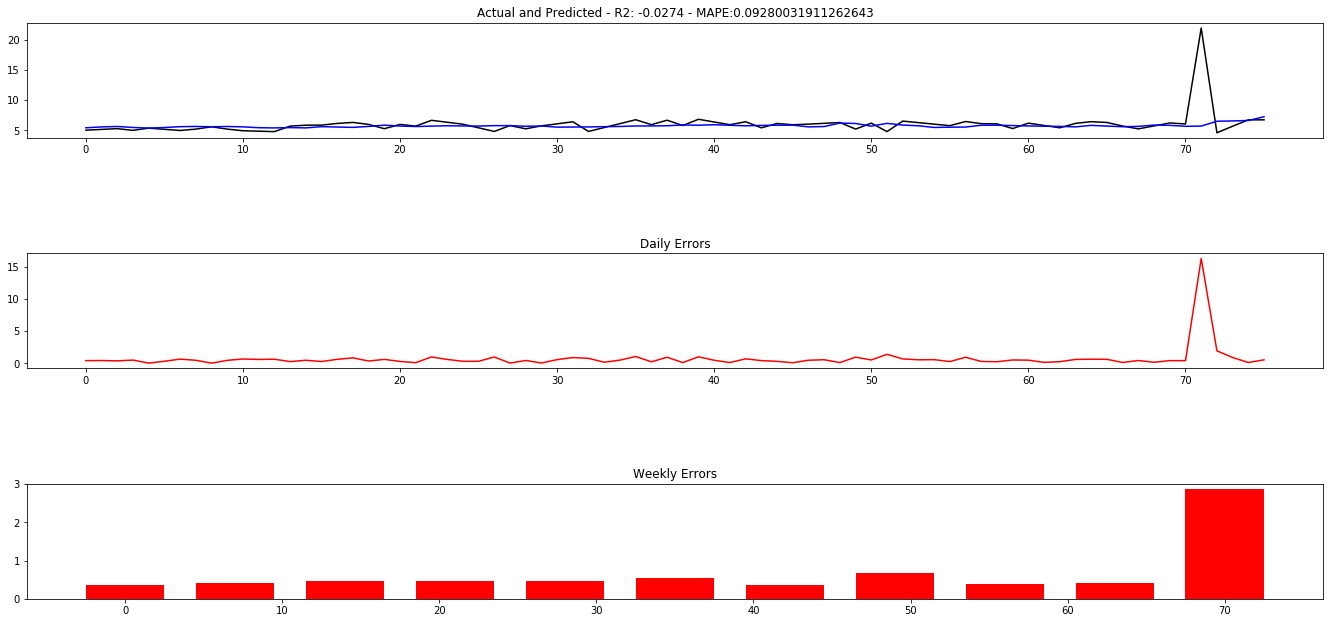

In [69]:
pred_y = model.predict(X_test)
pred_yy = minmax_denorm(test_daily_prices, pred_y, a=-1, b=1)
plot_prediction(not_norm_true_values, pred_yy)

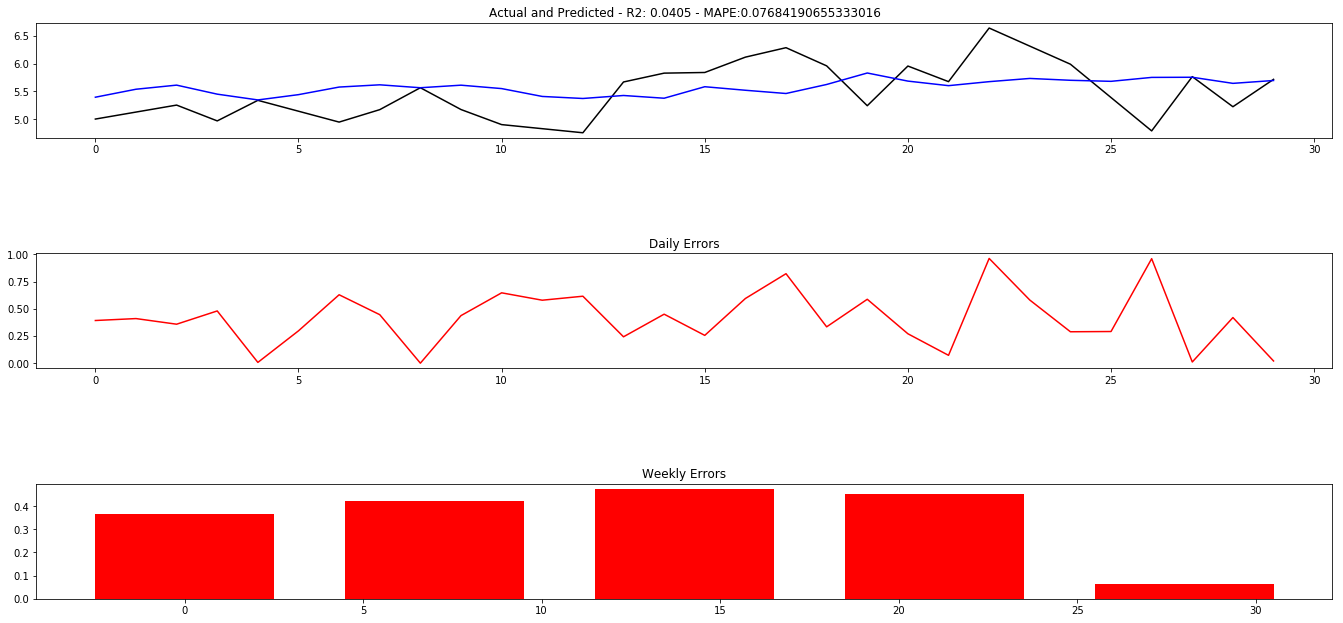

In [70]:
t=0
tp = 30
plot_prediction(not_norm_true_values[t:t+tp], pred_yy[t:t+tp])

# Training with Non-Normalized Data

In [71]:
nX_ = data_dict[w]['X']
nY_ = data_dict[w]['Y']
X_train_, X_val_, Y_train_, Y_val_ = get_train_validation(nX_, nY_)

In [72]:
print('X_train_: '+str(X_train_.shape))
print('X_val_: '+str(X_val_.shape))

X_train_: (584, 6, 2)
X_val_: (147, 6, 2)


In [73]:
print(X_train_[0])
print(Y_train_[0])
print('*'*50)
print(X_train_[1])
print(Y_train_[1])
print('*'*50)

[[5.06204651e+00 1.62244603e+03]
 [5.06204651e+00 4.90568464e+03]
 [4.05010000e+00 1.70635436e+04]
 [3.28664437e+00 4.84539564e+04]
 [3.13252469e+00 6.31609458e+04]
 [3.05356667e+00 4.35303300e+04]]
3.3421795035460997
**************************************************
[[5.06204651e+00 4.90568464e+03]
 [4.05010000e+00 1.70635436e+04]
 [3.28664437e+00 4.84539564e+04]
 [3.13252469e+00 6.31609458e+04]
 [3.05356667e+00 4.35303300e+04]
 [3.34217950e+00 2.33400263e+04]]
3.630792340425532
**************************************************


In [74]:
learning_rate=0.0001
epochs=1000
verbose=1
model_dir = 'models/'
model_save_name = model_dir + 'bidirlstm_multivariate_model_' + CURRENT_SUBSTANCE + '_interpolated_data_price_no_norm.h5'
    
#opt_1 = tf.keras.optimizers.Adam(learning_rate)
opt_1 = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
loss_func = tf.keras.losses.mean_squared_error

metrics = []
metrics.append(tf.keras.metrics.mean_absolute_error)
metrics.append(tf.keras.metrics.mean_squared_error)
metrics.append(tf.keras.metrics.mean_absolute_percentage_error)

print("Model will be saved at: " + model_save_name)
model.compile(optimizer=opt_1, 
                  loss=loss_func, 
                  metrics=metrics)
    
callbacks = []
cp = tf.keras.callbacks.ModelCheckpoint(filepath=model_save_name, verbose=1, save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
    
callbacks.append(cp)
callbacks.append(early_stop)

Model will be saved at: models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5


In [75]:
history = model.fit(X_train_, Y_train_, epochs = epochs,  batch_size = batch_size, 
                    verbose=verbose, validation_data=(X_val_, Y_val_), validation_split=0.8, callbacks=callbacks)

Train on 584 samples, validate on 147 samples
Epoch 1/1000
512/584 [=========================>....] - ETA: 0s - loss: 35.5645 - mean_absolute_error: 5.2640 - mean_squared_error: 35.5645 - mean_absolute_percentage_error: 114.0530
Epoch 00001: val_loss improved from inf to 38.84163, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==============================] - 3s 5ms/step - loss: 34.4496 - mean_absolute_error: 5.2284 - mean_squared_error: 34.4496 - mean_absolute_percentage_error: 114.0309 - val_loss: 38.8416 - val_mean_absolute_error: 6.1752 - val_mean_squared_error: 38.8416 - val_mean_absolute_percentage_error: 110.7074
Epoch 2/1000
512/584 [=========================>....] - ETA: 0s - loss: 29.8546 - mean_absolute_error: 5.1179 - mean_squared_error: 29.8546 - mean_absolute_percentage_error: 113.2826
Epoch 00002: val_loss improved from 38.84163 to 38.40512, saving model to models/bidirlstm_multivariate_model_paracetamol_inter

Epoch 14/1000
576/584 [============================>.] - ETA: 0s - loss: 30.1619 - mean_absolute_error: 4.7922 - mean_squared_error: 30.1619 - mean_absolute_percentage_error: 103.6655- ETA: 0s - loss: 31.5549 - mean_absolute_error: 4.8207 - mean_squared_error: 31.5549 - mean_absolute_percentage_error: 103.726
Epoch 00014: val_loss improved from 33.93898 to 33.55563, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==============================] - 0s 856us/step - loss: 30.0254 - mean_absolute_error: 4.7872 - mean_squared_error: 30.0254 - mean_absolute_percentage_error: 103.6608 - val_loss: 33.5556 - val_mean_absolute_error: 5.7316 - val_mean_squared_error: 33.5556 - val_mean_absolute_percentage_error: 102.5526
Epoch 15/1000
544/584 [==========================>...] - ETA: 0s - loss: 29.7937 - mean_absolute_error: 4.7584 - mean_squared_error: 29.7937 - mean_absolute_percentage_error: 102.9097
Epoch 00015: val_loss improved from 3

584/584 [==============================] - 0s 845us/step - loss: 26.4478 - mean_absolute_error: 4.3981 - mean_squared_error: 26.4478 - mean_absolute_percentage_error: 94.5066 - val_loss: 29.2347 - val_mean_absolute_error: 5.3415 - val_mean_squared_error: 29.2347 - val_mean_absolute_percentage_error: 95.3805
Epoch 27/1000
512/584 [=========================>....] - ETA: 0s - loss: 24.8424 - mean_absolute_error: 4.3200 - mean_squared_error: 24.8424 - mean_absolute_percentage_error: 93.8096
Epoch 00027: val_loss improved from 29.23471 to 28.90081, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==============================] - 0s 825us/step - loss: 26.1694 - mean_absolute_error: 4.3665 - mean_squared_error: 26.1694 - mean_absolute_percentage_error: 93.7674 - val_loss: 28.9008 - val_mean_absolute_error: 5.3102 - val_mean_squared_error: 28.9008 - val_mean_absolute_percentage_error: 94.8038
Epoch 28/1000
512/584 [===================

576/584 [============================>.] - ETA: 0s - loss: 23.1610 - mean_absolute_error: 3.9972 - mean_squared_error: 23.1610 - mean_absolute_percentage_error: 85.0427
Epoch 00039: val_loss improved from 25.40890 to 25.10228, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==============================] - 1s 869us/step - loss: 23.0647 - mean_absolute_error: 3.9954 - mean_squared_error: 23.0647 - mean_absolute_percentage_error: 85.0394 - val_loss: 25.1023 - val_mean_absolute_error: 4.9396 - val_mean_squared_error: 25.1023 - val_mean_absolute_percentage_error: 87.9862
Epoch 40/1000
512/584 [=========================>....] - ETA: 0s - loss: 22.6333 - mean_absolute_error: 3.9285 - mean_squared_error: 22.6333 - mean_absolute_percentage_error: 84.2816
Epoch 00040: val_loss improved from 25.10228 to 24.80511, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [================

Epoch 52/1000
512/584 [=========================>....] - ETA: 0s - loss: 20.0509 - mean_absolute_error: 3.6105 - mean_squared_error: 20.0509 - mean_absolute_percentage_error: 76.0360
Epoch 00052: val_loss improved from 21.71222 to 21.44938, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==============================] - 0s 821us/step - loss: 20.1308 - mean_absolute_error: 3.6096 - mean_squared_error: 20.1308 - mean_absolute_percentage_error: 75.9673 - val_loss: 21.4494 - val_mean_absolute_error: 4.5549 - val_mean_squared_error: 21.4494 - val_mean_absolute_percentage_error: 80.9083
Epoch 53/1000
512/584 [=========================>....] - ETA: 0s - loss: 20.9348 - mean_absolute_error: 3.6171 - mean_squared_error: 20.9348 - mean_absolute_percentage_error: 75.3957
Epoch 00053: val_loss improved from 21.44938 to 21.18686, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==

Epoch 65/1000
576/584 [============================>.] - ETA: 0s - loss: 17.7405 - mean_absolute_error: 3.2478 - mean_squared_error: 17.7405 - mean_absolute_percentage_error: 67.3152
Epoch 00065: val_loss improved from 18.46112 to 18.22777, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==============================] - 0s 839us/step - loss: 17.6066 - mean_absolute_error: 3.2402 - mean_squared_error: 17.6066 - mean_absolute_percentage_error: 67.2742 - val_loss: 18.2278 - val_mean_absolute_error: 4.1863 - val_mean_squared_error: 18.2278 - val_mean_absolute_percentage_error: 74.1282
Epoch 66/1000
576/584 [============================>.] - ETA: 0s - loss: 17.5529 - mean_absolute_error: 3.2182 - mean_squared_error: 17.5529 - mean_absolute_percentage_error: 66.6523 ETA: 0s - loss: 17.5132 - mean_absolute_error: 3.1898 - mean_squared_error: 17.5132 - mean_absolute_percentage_error: 66.50
Epoch 00066: val_loss improved from 18.22777

Epoch 78/1000
544/584 [==========================>...] - ETA: 0s - loss: 15.2951 - mean_absolute_error: 2.8698 - mean_squared_error: 15.2951 - mean_absolute_percentage_error: 59.0144
Epoch 00078: val_loss improved from 15.62788 to 15.42850, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==============================] - 0s 854us/step - loss: 15.4571 - mean_absolute_error: 2.8905 - mean_squared_error: 15.4571 - mean_absolute_percentage_error: 59.0581 - val_loss: 15.4285 - val_mean_absolute_error: 3.8407 - val_mean_squared_error: 15.4285 - val_mean_absolute_percentage_error: 67.9223
Epoch 79/1000
512/584 [=========================>....] - ETA: 0s - loss: 14.9505 - mean_absolute_error: 2.8499 - mean_squared_error: 14.9505 - mean_absolute_percentage_error: 58.5324
Epoch 00079: val_loss improved from 15.42850 to 15.23017, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==

Epoch 91/1000
576/584 [============================>.] - ETA: 0s - loss: 13.7760 - mean_absolute_error: 2.5673 - mean_squared_error: 13.7760 - mean_absolute_percentage_error: 51.2992
Epoch 00091: val_loss improved from 13.15501 to 12.98101, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==============================] - 0s 816us/step - loss: 13.6383 - mean_absolute_error: 2.5564 - mean_squared_error: 13.6383 - mean_absolute_percentage_error: 51.1984 - val_loss: 12.9810 - val_mean_absolute_error: 3.5118 - val_mean_squared_error: 12.9810 - val_mean_absolute_percentage_error: 62.0880
Epoch 92/1000
512/584 [=========================>....] - ETA: 0s - loss: 14.4274 - mean_absolute_error: 2.5565 - mean_squared_error: 14.4274 - mean_absolute_percentage_error: 50.6678
Epoch 00092: val_loss improved from 12.98101 to 12.80769, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==

Epoch 104/1000
512/584 [=========================>....] - ETA: 0s - loss: 13.2115 - mean_absolute_error: 2.2871 - mean_squared_error: 13.2115 - mean_absolute_percentage_error: 44.0248
Epoch 00104: val_loss improved from 11.04845 to 10.89578, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==============================] - 1s 873us/step - loss: 12.1431 - mean_absolute_error: 2.2444 - mean_squared_error: 12.1431 - mean_absolute_percentage_error: 43.8607 - val_loss: 10.8958 - val_mean_absolute_error: 3.2047 - val_mean_squared_error: 10.8958 - val_mean_absolute_percentage_error: 56.6387
Epoch 105/1000
512/584 [=========================>....] - ETA: 0s - loss: 13.0342 - mean_absolute_error: 2.2575 - mean_squared_error: 13.0342 - mean_absolute_percentage_error: 43.4843
Epoch 00105: val_loss improved from 10.89578 to 10.74906, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [

Epoch 117/1000
576/584 [============================>.] - ETA: 0s - loss: 11.0083 - mean_absolute_error: 1.9529 - mean_squared_error: 11.0083 - mean_absolute_percentage_error: 36.9290
Epoch 00117: val_loss improved from 9.23779 to 9.11151, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==============================] - 0s 833us/step - loss: 10.9092 - mean_absolute_error: 1.9505 - mean_squared_error: 10.9092 - mean_absolute_percentage_error: 36.9490 - val_loss: 9.1115 - val_mean_absolute_error: 2.9158 - val_mean_squared_error: 9.1115 - val_mean_absolute_percentage_error: 51.5135
Epoch 118/1000
512/584 [=========================>....] - ETA: 0s - loss: 11.5816 - mean_absolute_error: 1.9163 - mean_squared_error: 11.5816 - mean_absolute_percentage_error: 35.9407
Epoch 00118: val_loss improved from 9.11151 to 8.98666, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [======

Epoch 130/1000
576/584 [============================>.] - ETA: 0s - loss: 10.0166 - mean_absolute_error: 1.6813 - mean_squared_error: 10.0166 - mean_absolute_percentage_error: 30.5283
Epoch 00130: val_loss improved from 7.70156 to 7.59119, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==============================] - 0s 818us/step - loss: 9.9099 - mean_absolute_error: 1.6748 - mean_squared_error: 9.9099 - mean_absolute_percentage_error: 30.4623 - val_loss: 7.5912 - val_mean_absolute_error: 2.6443 - val_mean_squared_error: 7.5912 - val_mean_absolute_percentage_error: 46.6973
Epoch 131/1000
512/584 [=========================>....] - ETA: 0s - loss: 9.6888 - mean_absolute_error: 1.6403 - mean_squared_error: 9.6888 - mean_absolute_percentage_error: 29.9080
Epoch 00131: val_loss improved from 7.59119 to 7.48716, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==========

Epoch 143/1000
512/584 [=========================>....] - ETA: 0s - loss: 5.1796 - mean_absolute_error: 1.3274 - mean_squared_error: 5.1796 - mean_absolute_percentage_error: 24.3483
Epoch 00143: val_loss improved from 6.40548 to 6.31777, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==============================] - 0s 797us/step - loss: 9.1160 - mean_absolute_error: 1.4253 - mean_squared_error: 9.1160 - mean_absolute_percentage_error: 24.6566 - val_loss: 6.3178 - val_mean_absolute_error: 2.3928 - val_mean_squared_error: 6.3178 - val_mean_absolute_percentage_error: 42.2351
Epoch 144/1000
512/584 [=========================>....] - ETA: 0s - loss: 10.0478 - mean_absolute_error: 1.4443 - mean_squared_error: 10.0478 - mean_absolute_percentage_error: 24.3593
Epoch 00144: val_loss improved from 6.31777 to 6.22888, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==========

Epoch 156/1000
512/584 [=========================>....] - ETA: 0s - loss: 5.2626 - mean_absolute_error: 1.1898 - mean_squared_error: 5.2626 - mean_absolute_percentage_error: 20.6171
Epoch 00156: val_loss improved from 5.33630 to 5.25542, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==============================] - 0s 854us/step - loss: 8.5027 - mean_absolute_error: 1.2380 - mean_squared_error: 8.5027 - mean_absolute_percentage_error: 20.6214 - val_loss: 5.2554 - val_mean_absolute_error: 2.1601 - val_mean_squared_error: 5.2554 - val_mean_absolute_percentage_error: 38.1067
Epoch 157/1000
512/584 [=========================>....] - ETA: 0s - loss: 8.2502 - mean_absolute_error: 1.2066 - mean_squared_error: 8.2502 - mean_absolute_percentage_error: 20.3468
Epoch 00157: val_loss improved from 5.25542 to 5.18119, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [============

Epoch 169/1000
512/584 [=========================>....] - ETA: 0s - loss: 8.2454 - mean_absolute_error: 1.1191 - mean_squared_error: 8.2454 - mean_absolute_percentage_error: 18.3788
Epoch 00169: val_loss improved from 4.45689 to 4.39392, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==============================] - 0s 823us/step - loss: 8.0436 - mean_absolute_error: 1.1042 - mean_squared_error: 8.0436 - mean_absolute_percentage_error: 18.0069 - val_loss: 4.3939 - val_mean_absolute_error: 1.9506 - val_mean_squared_error: 4.3939 - val_mean_absolute_percentage_error: 34.3887
Epoch 170/1000
512/584 [=========================>....] - ETA: 0s - loss: 8.5324 - mean_absolute_error: 1.1263 - mean_squared_error: 8.5324 - mean_absolute_percentage_error: 18.1812  
Epoch 00170: val_loss improved from 4.39392 to 4.33530, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==========

Epoch 182/1000
576/584 [============================>.] - ETA: 0s - loss: 7.7553 - mean_absolute_error: 1.0154 - mean_squared_error: 7.7553 - mean_absolute_percentage_error: 16.5761
Epoch 00182: val_loss improved from 3.73093 to 3.68403, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==============================] - 1s 866us/step - loss: 7.7024 - mean_absolute_error: 1.0185 - mean_squared_error: 7.7024 - mean_absolute_percentage_error: 16.6213 - val_loss: 3.6840 - val_mean_absolute_error: 1.7586 - val_mean_squared_error: 3.6840 - val_mean_absolute_percentage_error: 30.9831
Epoch 183/1000
512/584 [=========================>....] - ETA: 0s - loss: 8.4137 - mean_absolute_error: 1.0159 - mean_squared_error: 8.4137 - mean_absolute_percentage_error: 16.3126
Epoch 00183: val_loss improved from 3.68403 to 3.63746, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [============

Epoch 195/1000
512/584 [=========================>....] - ETA: 0s - loss: 4.2831 - mean_absolute_error: 0.9319 - mean_squared_error: 4.2831 - mean_absolute_percentage_error: 16.3381
Epoch 00195: val_loss improved from 3.18006 to 3.14460, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==============================] - 0s 819us/step - loss: 7.4734 - mean_absolute_error: 0.9778 - mean_squared_error: 7.4734 - mean_absolute_percentage_error: 16.2725 - val_loss: 3.1446 - val_mean_absolute_error: 1.5969 - val_mean_squared_error: 3.1446 - val_mean_absolute_percentage_error: 28.1132
Epoch 196/1000
512/584 [=========================>....] - ETA: 0s - loss: 8.2945 - mean_absolute_error: 1.0175 - mean_squared_error: 8.2945 - mean_absolute_percentage_error: 16.6890
Epoch 00196: val_loss improved from 3.14460 to 3.10671, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [============

Epoch 208/1000
512/584 [=========================>....] - ETA: 0s - loss: 7.5854 - mean_absolute_error: 0.9673 - mean_squared_error: 7.5854 - mean_absolute_percentage_error: 16.5325
Epoch 00208: val_loss improved from 2.75124 to 2.72252, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==============================] - 0s 842us/step - loss: 7.3208 - mean_absolute_error: 0.9618 - mean_squared_error: 7.3208 - mean_absolute_percentage_error: 16.4464 - val_loss: 2.7225 - val_mean_absolute_error: 1.4573 - val_mean_squared_error: 2.7225 - val_mean_absolute_percentage_error: 25.6378
Epoch 209/1000
512/584 [=========================>....] - ETA: 0s - loss: 7.9192 - mean_absolute_error: 0.9632 - mean_squared_error: 7.9192 - mean_absolute_percentage_error: 16.4302
Epoch 00209: val_loss improved from 2.72252 to 2.69378, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [============

Epoch 221/1000
512/584 [=========================>....] - ETA: 0s - loss: 7.4803 - mean_absolute_error: 0.9687 - mean_squared_error: 7.4803 - mean_absolute_percentage_error: 16.9393
Epoch 00221: val_loss improved from 2.42133 to 2.39781, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==============================] - 0s 828us/step - loss: 7.2243 - mean_absolute_error: 0.9620 - mean_squared_error: 7.2243 - mean_absolute_percentage_error: 16.9243 - val_loss: 2.3978 - val_mean_absolute_error: 1.3397 - val_mean_squared_error: 2.3978 - val_mean_absolute_percentage_error: 23.5511
Epoch 222/1000
512/584 [=========================>....] - ETA: 0s - loss: 2.3407 - mean_absolute_error: 0.8327 - mean_squared_error: 2.3407 - mean_absolute_percentage_error: 16.7475
Epoch 00222: val_loss improved from 2.39781 to 2.37581, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [============

Epoch 234/1000
512/584 [=========================>....] - ETA: 0s - loss: 3.0130 - mean_absolute_error: 0.8765 - mean_squared_error: 3.0130 - mean_absolute_percentage_error: 17.2850
Epoch 00234: val_loss improved from 2.16544 to 2.15434, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==============================] - 0s 807us/step - loss: 7.1647 - mean_absolute_error: 0.9703 - mean_squared_error: 7.1647 - mean_absolute_percentage_error: 17.5093 - val_loss: 2.1543 - val_mean_absolute_error: 1.2439 - val_mean_squared_error: 2.1543 - val_mean_absolute_percentage_error: 21.8514
Epoch 235/1000
512/584 [=========================>....] - ETA: 0s - loss: 8.0738 - mean_absolute_error: 1.0108 - mean_squared_error: 8.0738 - mean_absolute_percentage_error: 17.7833
Epoch 00235: val_loss improved from 2.15434 to 2.13558, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [============

Epoch 247/1000
512/584 [=========================>....] - ETA: 0s - loss: 2.9285 - mean_absolute_error: 0.8787 - mean_squared_error: 2.9285 - mean_absolute_percentage_error: 17.7954
Epoch 00247: val_loss improved from 1.99529 to 1.98510, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==============================] - 0s 845us/step - loss: 7.1342 - mean_absolute_error: 0.9812 - mean_squared_error: 7.1342 - mean_absolute_percentage_error: 18.0493 - val_loss: 1.9851 - val_mean_absolute_error: 1.1725 - val_mean_squared_error: 1.9851 - val_mean_absolute_percentage_error: 20.5843
Epoch 248/1000
512/584 [=========================>....] - ETA: 0s - loss: 3.9194 - mean_absolute_error: 0.9188 - mean_squared_error: 3.9194 - mean_absolute_percentage_error: 17.9848
Epoch 00248: val_loss improved from 1.98510 to 1.97421, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [============

Epoch 260/1000
512/584 [=========================>....] - ETA: 0s - loss: 6.7579 - mean_absolute_error: 0.9457 - mean_squared_error: 6.7579 - mean_absolute_percentage_error: 18.2626
Epoch 00260: val_loss improved from 1.86816 to 1.86281, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==============================] - 0s 821us/step - loss: 7.1181 - mean_absolute_error: 0.9920 - mean_squared_error: 7.1181 - mean_absolute_percentage_error: 18.5193 - val_loss: 1.8628 - val_mean_absolute_error: 1.1179 - val_mean_squared_error: 1.8628 - val_mean_absolute_percentage_error: 19.6157
Epoch 261/1000
576/584 [============================>.] - ETA: 0s - loss: 7.1008 - mean_absolute_error: 0.9831 - mean_squared_error: 7.1008 - mean_absolute_percentage_error: 18.4468
Epoch 00261: val_loss improved from 1.86281 to 1.85682, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [============

Epoch 273/1000
512/584 [=========================>....] - ETA: 0s - loss: 7.5061 - mean_absolute_error: 0.9965 - mean_squared_error: 7.5061 - mean_absolute_percentage_error: 18.6592
Epoch 00273: val_loss improved from 1.78283 to 1.77571, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==============================] - 0s 804us/step - loss: 7.1103 - mean_absolute_error: 1.0014 - mean_squared_error: 7.1103 - mean_absolute_percentage_error: 18.8949 - val_loss: 1.7757 - val_mean_absolute_error: 1.0773 - val_mean_squared_error: 1.7757 - val_mean_absolute_percentage_error: 18.8944
Epoch 274/1000
512/584 [=========================>....] - ETA: 0s - loss: 3.7964 - mean_absolute_error: 0.9391 - mean_squared_error: 3.7964 - mean_absolute_percentage_error: 19.0124
Epoch 00274: val_loss improved from 1.77571 to 1.77151, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [============

Epoch 286/1000
512/584 [=========================>....] - ETA: 0s - loss: 7.2225 - mean_absolute_error: 1.0026 - mean_squared_error: 7.2225 - mean_absolute_percentage_error: 19.2119
Epoch 00286: val_loss improved from 1.72155 to 1.71697, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==============================] - 0s 819us/step - loss: 7.1068 - mean_absolute_error: 1.0087 - mean_squared_error: 7.1068 - mean_absolute_percentage_error: 19.1799 - val_loss: 1.7170 - val_mean_absolute_error: 1.0495 - val_mean_squared_error: 1.7170 - val_mean_absolute_percentage_error: 18.4036
Epoch 287/1000
512/584 [=========================>....] - ETA: 0s - loss: 3.4434 - mean_absolute_error: 0.8855 - mean_squared_error: 3.4434 - mean_absolute_percentage_error: 18.4720
Epoch 00287: val_loss improved from 1.71697 to 1.71662, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [============

512/584 [=========================>....] - ETA: 0s - loss: 3.4698 - mean_absolute_error: 0.9253 - mean_squared_error: 3.4698 - mean_absolute_percentage_error: 19.2125
Epoch 00299: val_loss did not improve from 1.67648
584/584 [==============================] - 0s 778us/step - loss: 7.1055 - mean_absolute_error: 1.0140 - mean_squared_error: 7.1055 - mean_absolute_percentage_error: 19.3760 - val_loss: 1.6808 - val_mean_absolute_error: 1.0321 - val_mean_squared_error: 1.6808 - val_mean_absolute_percentage_error: 18.0971
Epoch 300/1000
512/584 [=========================>....] - ETA: 0s - loss: 7.3037 - mean_absolute_error: 0.9880 - mean_squared_error: 7.3037 - mean_absolute_percentage_error: 19.2279
Epoch 00300: val_loss did not improve from 1.67648
584/584 [==============================] - 0s 772us/step - loss: 7.1052 - mean_absolute_error: 1.0136 - mean_squared_error: 7.1052 - mean_absolute_percentage_error: 19.3636 - val_loss: 1.6807 - val_mean_absolute_error: 1.0320 - val_mean_squared

Epoch 313/1000
512/584 [=========================>....] - ETA: 0s - loss: 7.3535 - mean_absolute_error: 1.0240 - mean_squared_error: 7.3535 - mean_absolute_percentage_error: 19.5962
Epoch 00313: val_loss improved from 1.65724 to 1.65612, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==============================] - 0s 806us/step - loss: 7.1047 - mean_absolute_error: 1.0171 - mean_squared_error: 7.1047 - mean_absolute_percentage_error: 19.4937 - val_loss: 1.6561 - val_mean_absolute_error: 1.0200 - val_mean_squared_error: 1.6561 - val_mean_absolute_percentage_error: 17.8851
Epoch 314/1000
512/584 [=========================>....] - ETA: 0s - loss: 7.3167 - mean_absolute_error: 1.0130 - mean_squared_error: 7.3167 - mean_absolute_percentage_error: 19.5556
Epoch 00314: val_loss did not improve from 1.65612
584/584 [==============================] - 0s 777us/step - loss: 7.1048 - mean_absolute_error: 1.0169 - mean_squared_error: 7

Epoch 327/1000
512/584 [=========================>....] - ETA: 0s - loss: 7.9161 - mean_absolute_error: 1.0571 - mean_squared_error: 7.9161 - mean_absolute_percentage_error: 20.1456
Epoch 00327: val_loss did not improve from 1.62415
584/584 [==============================] - 0s 775us/step - loss: 7.1049 - mean_absolute_error: 1.0211 - mean_squared_error: 7.1049 - mean_absolute_percentage_error: 19.6369 - val_loss: 1.6288 - val_mean_absolute_error: 1.0065 - val_mean_squared_error: 1.6288 - val_mean_absolute_percentage_error: 17.6469
Epoch 328/1000
512/584 [=========================>....] - ETA: 0s - loss: 7.9310 - mean_absolute_error: 1.0466 - mean_squared_error: 7.9310 - mean_absolute_percentage_error: 19.5056
Epoch 00328: val_loss improved from 1.62415 to 1.62110, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_price_no_norm.h5
584/584 [==============================] - 0s 807us/step - loss: 7.1047 - mean_absolute_error: 1.0220 - mean_squared_error: 7

Epoch 342/1000
512/584 [=========================>....] - ETA: 0s - loss: 7.9342 - mean_absolute_error: 1.0451 - mean_squared_error: 7.9342 - mean_absolute_percentage_error: 19.6578
Epoch 00342: val_loss did not improve from 1.60804
584/584 [==============================] - 0s 763us/step - loss: 7.1046 - mean_absolute_error: 1.0243 - mean_squared_error: 7.1046 - mean_absolute_percentage_error: 19.7520 - val_loss: 1.6090 - val_mean_absolute_error: 0.9966 - val_mean_squared_error: 1.6090 - val_mean_absolute_percentage_error: 17.4719
Epoch 343/1000
512/584 [=========================>....] - ETA: 0s - loss: 3.8578 - mean_absolute_error: 0.9521 - mean_squared_error: 3.8578 - mean_absolute_percentage_error: 19.2657
Epoch 00343: val_loss did not improve from 1.60804
584/584 [==============================] - 0s 773us/step - loss: 7.1044 - mean_absolute_error: 1.0238 - mean_squared_error: 7.1044 - mean_absolute_percentage_error: 19.7366 - val_loss: 1.6143 - val_mean_absolute_error: 0.9992 - v

Epoch 357/1000
512/584 [=========================>....] - ETA: 0s - loss: 3.5240 - mean_absolute_error: 0.9472 - mean_squared_error: 3.5240 - mean_absolute_percentage_error: 19.5287
Epoch 00357: val_loss did not improve from 1.60116
584/584 [==============================] - 0s 760us/step - loss: 7.1044 - mean_absolute_error: 1.0235 - mean_squared_error: 7.1044 - mean_absolute_percentage_error: 19.7257 - val_loss: 1.6127 - val_mean_absolute_error: 0.9985 - val_mean_squared_error: 1.6127 - val_mean_absolute_percentage_error: 17.5051
Epoch 358/1000
512/584 [=========================>....] - ETA: 0s - loss: 7.9378 - mean_absolute_error: 1.0552 - mean_squared_error: 7.9378 - mean_absolute_percentage_error: 20.0108
Epoch 00358: val_loss did not improve from 1.60116
584/584 [==============================] - 0s 779us/step - loss: 7.1046 - mean_absolute_error: 1.0236 - mean_squared_error: 7.1046 - mean_absolute_percentage_error: 19.7263 - val_loss: 1.6127 - val_mean_absolute_error: 0.9985 - v

512/584 [=========================>....] - ETA: 0s - loss: 3.5217 - mean_absolute_error: 0.9483 - mean_squared_error: 3.5217 - mean_absolute_percentage_error: 19.6262
Epoch 00372: val_loss did not improve from 1.59725
584/584 [==============================] - 0s 769us/step - loss: 7.1045 - mean_absolute_error: 1.0246 - mean_squared_error: 7.1045 - mean_absolute_percentage_error: 19.7641 - val_loss: 1.6078 - val_mean_absolute_error: 0.9960 - val_mean_squared_error: 1.6078 - val_mean_absolute_percentage_error: 17.4612
Epoch 373/1000
512/584 [=========================>....] - ETA: 0s - loss: 7.3870 - mean_absolute_error: 1.0141 - mean_squared_error: 7.3870 - mean_absolute_percentage_error: 19.6700
Epoch 00373: val_loss did not improve from 1.59725
584/584 [==============================] - 0s 779us/step - loss: 7.1045 - mean_absolute_error: 1.0243 - mean_squared_error: 7.1045 - mean_absolute_percentage_error: 19.7520 - val_loss: 1.6091 - val_mean_absolute_error: 0.9966 - val_mean_squared

512/584 [=========================>....] - ETA: 0s - loss: 7.8901 - mean_absolute_error: 1.0602 - mean_squared_error: 7.8901 - mean_absolute_percentage_error: 20.1372
Epoch 00387: val_loss did not improve from 1.59060
584/584 [==============================] - 0s 780us/step - loss: 7.1045 - mean_absolute_error: 1.0256 - mean_squared_error: 7.1045 - mean_absolute_percentage_error: 19.7990 - val_loss: 1.6022 - val_mean_absolute_error: 0.9932 - val_mean_squared_error: 1.6022 - val_mean_absolute_percentage_error: 17.4117
Epoch 388/1000
512/584 [=========================>....] - ETA: 0s - loss: 3.9543 - mean_absolute_error: 0.9800 - mean_squared_error: 3.9543 - mean_absolute_percentage_error: 20.0861
Epoch 00388: val_loss did not improve from 1.59060
584/584 [==============================] - 0s 770us/step - loss: 7.1046 - mean_absolute_error: 1.0250 - mean_squared_error: 7.1046 - mean_absolute_percentage_error: 19.7793 - val_loss: 1.6067 - val_mean_absolute_error: 0.9954 - val_mean_squared

512/584 [=========================>....] - ETA: 0s - loss: 7.3034 - mean_absolute_error: 1.0197 - mean_squared_error: 7.3034 - mean_absolute_percentage_error: 19.8374
Epoch 00402: val_loss did not improve from 1.59060
584/584 [==============================] - 0s 764us/step - loss: 7.1044 - mean_absolute_error: 1.0222 - mean_squared_error: 7.1044 - mean_absolute_percentage_error: 19.6765 - val_loss: 1.6202 - val_mean_absolute_error: 1.0022 - val_mean_squared_error: 1.6202 - val_mean_absolute_percentage_error: 17.5712
Epoch 403/1000
512/584 [=========================>....] - ETA: 0s - loss: 7.9814 - mean_absolute_error: 1.0615 - mean_squared_error: 7.9814 - mean_absolute_percentage_error: 19.9364
Epoch 00403: val_loss did not improve from 1.59060
584/584 [==============================] - 0s 750us/step - loss: 7.1046 - mean_absolute_error: 1.0229 - mean_squared_error: 7.1046 - mean_absolute_percentage_error: 19.7034 - val_loss: 1.6151 - val_mean_absolute_error: 0.9997 - val_mean_squared

512/584 [=========================>....] - ETA: 0s - loss: 7.3208 - mean_absolute_error: 1.0286 - mean_squared_error: 7.3208 - mean_absolute_percentage_error: 19.9352
Epoch 00417: val_loss did not improve from 1.59060
584/584 [==============================] - 0s 762us/step - loss: 7.1053 - mean_absolute_error: 1.0228 - mean_squared_error: 7.1053 - mean_absolute_percentage_error: 19.6963 - val_loss: 1.6173 - val_mean_absolute_error: 1.0008 - val_mean_squared_error: 1.6173 - val_mean_absolute_percentage_error: 17.5454
Epoch 418/1000
512/584 [=========================>....] - ETA: 0s - loss: 7.4615 - mean_absolute_error: 1.0282 - mean_squared_error: 7.4615 - mean_absolute_percentage_error: 19.7520
Epoch 00418: val_loss did not improve from 1.59060
584/584 [==============================] - 0s 782us/step - loss: 7.1043 - mean_absolute_error: 1.0227 - mean_squared_error: 7.1043 - mean_absolute_percentage_error: 19.6952 - val_loss: 1.6195 - val_mean_absolute_error: 1.0019 - val_mean_squared

512/584 [=========================>....] - ETA: 0s - loss: 8.0091 - mean_absolute_error: 1.0682 - mean_squared_error: 8.0091 - mean_absolute_percentage_error: 19.8682
Epoch 00432: val_loss did not improve from 1.59060
584/584 [==============================] - 0s 764us/step - loss: 7.1046 - mean_absolute_error: 1.0205 - mean_squared_error: 7.1046 - mean_absolute_percentage_error: 19.6177 - val_loss: 1.6299 - val_mean_absolute_error: 1.0071 - val_mean_squared_error: 1.6299 - val_mean_absolute_percentage_error: 17.6567
Epoch 433/1000
512/584 [=========================>....] - ETA: 0s - loss: 7.7849 - mean_absolute_error: 1.0309 - mean_squared_error: 7.7849 - mean_absolute_percentage_error: 19.4167
Epoch 00433: val_loss did not improve from 1.59060
584/584 [==============================] - 0s 777us/step - loss: 7.1043 - mean_absolute_error: 1.0210 - mean_squared_error: 7.1043 - mean_absolute_percentage_error: 19.6335 - val_loss: 1.6300 - val_mean_absolute_error: 1.0071 - val_mean_squared

576/584 [============================>.] - ETA: 0s - loss: 7.1920 - mean_absolute_error: 1.0226 - mean_squared_error: 7.1920 - mean_absolute_percentage_error: 19.5740
Epoch 00447: val_loss did not improve from 1.59060
584/584 [==============================] - 0s 784us/step - loss: 7.1054 - mean_absolute_error: 1.0200 - mean_squared_error: 7.1054 - mean_absolute_percentage_error: 19.5962 - val_loss: 1.6376 - val_mean_absolute_error: 1.0109 - val_mean_squared_error: 1.6376 - val_mean_absolute_percentage_error: 17.7237
Epoch 448/1000
512/584 [=========================>....] - ETA: 0s - loss: 7.4895 - mean_absolute_error: 1.0104 - mean_squared_error: 7.4895 - mean_absolute_percentage_error: 19.2479
Epoch 00448: val_loss did not improve from 1.59060
584/584 [==============================] - 0s 760us/step - loss: 7.1044 - mean_absolute_error: 1.0202 - mean_squared_error: 7.1044 - mean_absolute_percentage_error: 19.6049 - val_loss: 1.6335 - val_mean_absolute_error: 1.0089 - val_mean_squared

512/584 [=========================>....] - ETA: 0s - loss: 7.9980 - mean_absolute_error: 1.0601 - mean_squared_error: 7.9980 - mean_absolute_percentage_error: 19.7864
Epoch 00462: val_loss did not improve from 1.59060
584/584 [==============================] - 0s 840us/step - loss: 7.1050 - mean_absolute_error: 1.0243 - mean_squared_error: 7.1050 - mean_absolute_percentage_error: 19.7505 - val_loss: 1.6091 - val_mean_absolute_error: 0.9967 - val_mean_squared_error: 1.6091 - val_mean_absolute_percentage_error: 17.4730
Epoch 463/1000
512/584 [=========================>....] - ETA: 0s - loss: 8.0009 - mean_absolute_error: 1.0665 - mean_squared_error: 8.0009 - mean_absolute_percentage_error: 19.9239
Epoch 00463: val_loss did not improve from 1.59060
584/584 [==============================] - 1s 876us/step - loss: 7.1047 - mean_absolute_error: 1.0245 - mean_squared_error: 7.1047 - mean_absolute_percentage_error: 19.7585 - val_loss: 1.6069 - val_mean_absolute_error: 0.9956 - val_mean_squared

In [76]:
model.evaluate(X_val_, Y_val_)

147/147 [==============================] - 0s 2ms/step


[1.6264199707783809,
 1.0053354161126273,
 1.6264199707783809,
 17.625950398088314]

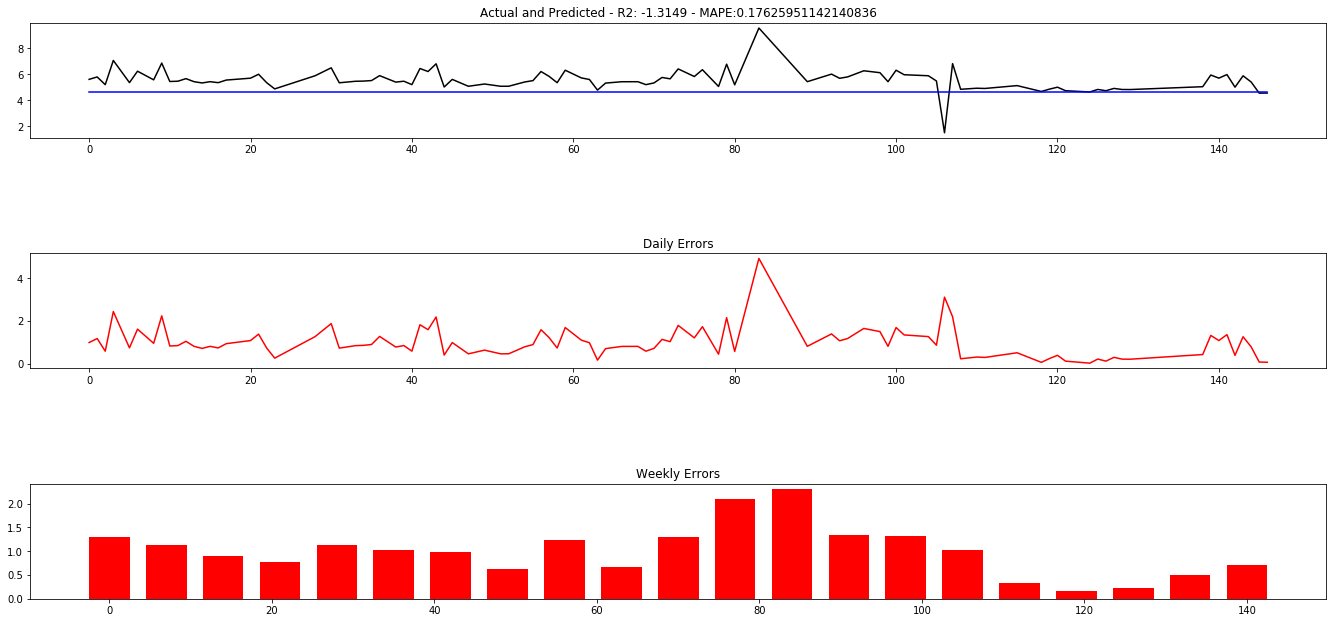

In [77]:
plot_prediction(Y_val_, model.predict(X_val_))

# Test Non-Normalized Model

In [78]:
X_test_ = test_data_dict[w]['X']
Y_test_ = test_data_dict[w]['Y']

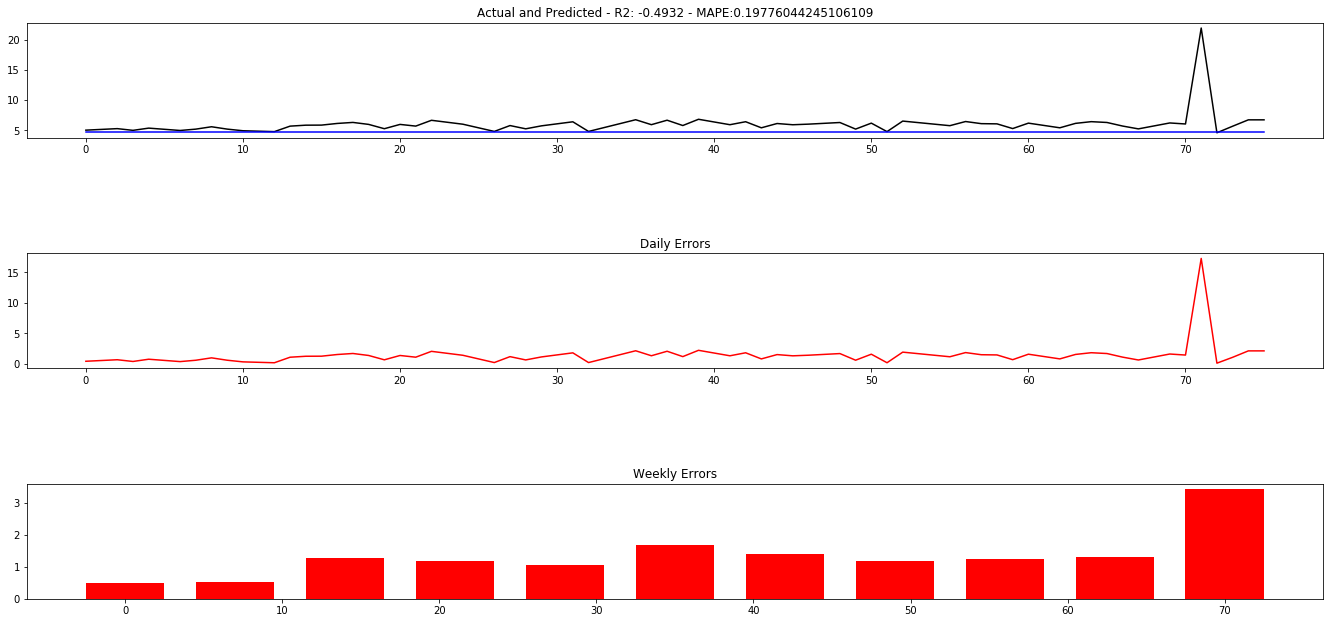

In [79]:
pred_y_ = model.predict(X_test_)
plot_prediction(Y_test_, pred_y_)

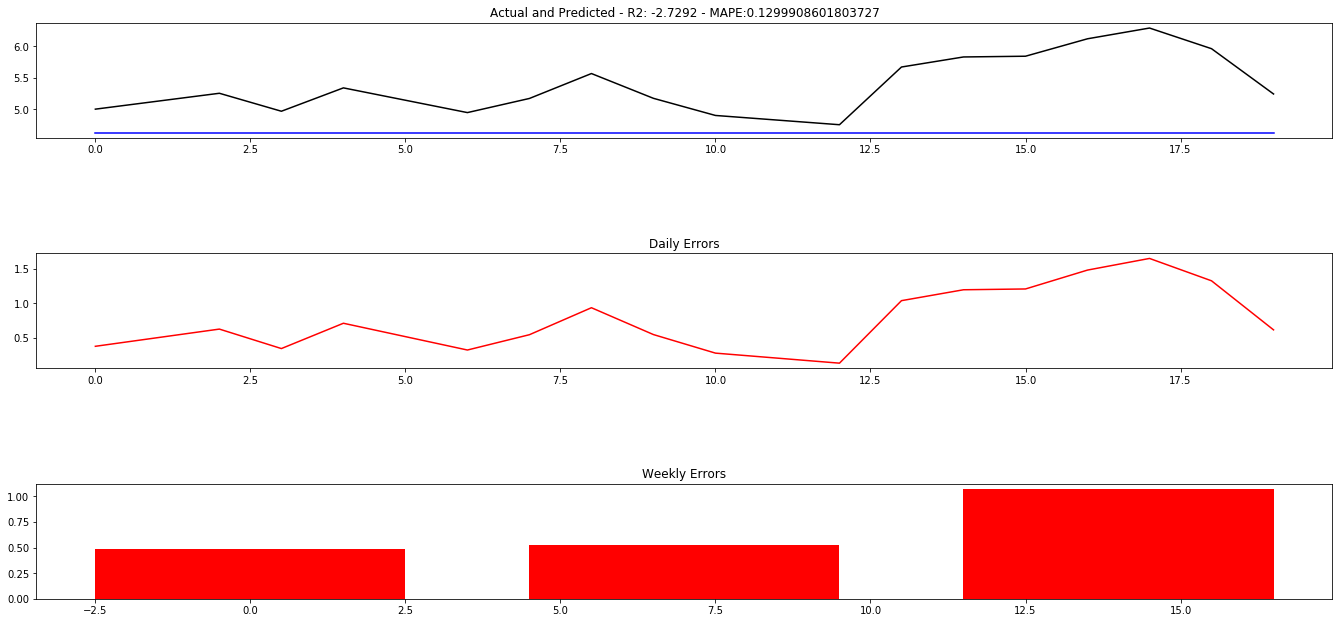

In [80]:
t=0
tp = 20
plot_prediction(Y_test_[t:t+tp], pred_y_[t:t+tp])